In [15]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic Gaussian mixture data for 3 classes
def generate_gaussian_mixture(n_samples=10000, n_features=2, n_classes=3, class_sep=2.0, random_state=42):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_classes=n_classes,
        n_clusters_per_class=1,
        class_sep=class_sep,
        random_state=random_state,
    )
    return X, y

from sklearn.preprocessing import StandardScaler

# Task A: Baseline task with Gaussian mixture and moderate separation
X_A, y_A = generate_gaussian_mixture(n_samples=20000, n_features=2, n_classes=3, class_sep=2.2)

# Task B: Scaled, rotated, and nonlinear
X_B, y_B = generate_gaussian_mixture(n_samples=20000, n_features=2, n_classes=3, class_sep=4.2)
scaler = StandardScaler()
X_B = scaler.fit_transform(X_B) * 1.8  # Scale Task B features
rotation_matrix_B = np.array([[0.8, -0.6], [0.6, 0.8]])  # Rotate ~36 degrees
X_B = np.dot(X_B, rotation_matrix_B)  # Apply rotation
X_B = np.sin(X_B)  # Add non-linearity (sin transformation)

# Task C: Rotated with noise and variable scaling
X_C, y_C = generate_gaussian_mixture(n_samples=20000, n_features=2, n_classes=3, class_sep=1.3)
rotation_matrix_C = np.array([[0.5, -0.866], [0.866, 0.5]])  # Rotate ~60 degrees
X_C = np.dot(X_C, rotation_matrix_C)  # Apply unique rotation
X_C += np.random.normal(0, 0.2, X_C.shape)  # Increase noise
scaling_factors_C = np.random.uniform(0.5, 1.5, size=(3,))
X_C = np.array([x * scaling_factors_C[label] for x, label in zip(X_C, y_C)])  # Scale based on labels
X_C = X_C[:, :2] 

# Function to split and prepare datasets
def prepare_datasets(X, y):
    # Split into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create TensorDataset objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    return train_dataset, val_dataset, test_dataset

# Prepare datasets for Task A
train_dataset_1, val_dataset_1, test_dataset_1 = prepare_datasets(X_A, y_A)

# Prepare datasets for Task B
train_dataset_2, val_dataset_2, test_dataset_2 = prepare_datasets(X_B, y_B)

# Prepare datasets for Task C
train_dataset_3, val_dataset_3, test_dataset_3 = prepare_datasets(X_C, y_C)

# Create DataLoaders
batch_size = 64

# Task A DataLoaders
train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=batch_size, shuffle=False)
test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)

# Task B DataLoaders
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=False)

# Task C DataLoaders
train_loader_3 = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=batch_size, shuffle=False)
test_loader_3 = DataLoader(test_dataset_3, batch_size=batch_size, shuffle=False)

# Verify dataset shapes
print(f"Task A: Train {len(train_dataset_1)}, Val {len(val_dataset_1)}, Test {len(test_dataset_1)}")
print(f"Task B: Train {len(train_dataset_2)}, Val {len(val_dataset_2)}, Test {len(test_dataset_2)}")
print(f"Task C: Train {len(train_dataset_3)}, Val {len(val_dataset_3)}, Test {len(test_dataset_3)}")


Task A: Train 14000, Val 3000, Test 3000
Task B: Train 14000, Val 3000, Test 3000
Task C: Train 14000, Val 3000, Test 3000


In [21]:
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch.utils.data import Dataset

class SinewaveDataset(Dataset):
    def __init__(self, num_samples, x_range, func, noise=0.0):
        self.x_values = np.linspace(x_range[0], x_range[1], num_samples)
        self.y_values = func(self.x_values)
        if noise > 0.0:
            self.y_values += np.random.normal(0, noise, size=self.y_values.shape)
        
        # Normalize targets to [-1, 1]
        self.y_values = (self.y_values - np.min(self.y_values)) / (np.max(self.y_values) - np.min(self.y_values)) * 2 - 1

        self.x_values = torch.tensor(self.x_values, dtype=torch.float32).unsqueeze(1)
        self.y_values = torch.tensor(self.y_values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.x_values)

    def __getitem__(self, idx):
        return self.x_values[idx], self.y_values[idx]


# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define shapes for each class
# Define shapes for each class with all required parameters
# Class A: 
class_A = SinewaveDataset(
    num_samples=20000,
    x_range=(0, 2 * np.pi),
    func=lambda x: np.sin(x),
    noise=0.1
)


# Class B: 
class_B = SinewaveDataset(
    num_samples=20000,
    x_range=(0, 2 * np.pi),
    func=lambda x: np.sin(2 * x), 
    noise=0.1
)


# Class C: 
class_C = SinewaveDataset(
    num_samples=20000,
    x_range=(0, 2 * np.pi),
    func=lambda x: (1 + 0.5 * np.sin(0.5 * x)) * np.sin(0.5 * x),  
    noise=0.1
)


# Split datasets
def split_dataset(full_dataset, train_ratio, val_ratio, test_ratio):
    total_size = len(full_dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size
    return random_split(full_dataset, [train_size, val_size, test_size])

train_dataset_1, val_dataset_1, test_dataset_1 = split_dataset(class_A, train_ratio, val_ratio, test_ratio)
train_dataset_2, val_dataset_2, test_dataset_2 = split_dataset(class_B, train_ratio, val_ratio, test_ratio)
train_dataset_3, val_dataset_3, test_dataset_3 = split_dataset(class_C, train_ratio, val_ratio, test_ratio)

# Create DataLoaders
train_loader_1 = DataLoader(train_dataset_1, batch_size=64, shuffle=True)
val_loader_1 = DataLoader(val_dataset_1, batch_size=64, shuffle=False)
test_loader_1 = DataLoader(test_dataset_1, batch_size=64, shuffle=False)

train_loader_2 = DataLoader(train_dataset_2, batch_size=64, shuffle=True)
val_loader_2 = DataLoader(val_dataset_2, batch_size=64, shuffle=False)
test_loader_2 = DataLoader(test_dataset_2, batch_size=64, shuffle=False)

train_loader_3 = DataLoader(train_dataset_3, batch_size=64, shuffle=True)
val_loader_3 = DataLoader(val_dataset_3, batch_size=64, shuffle=False)
test_loader_3 = DataLoader(test_dataset_3, batch_size=64, shuffle=False)



In [22]:
print(f"Mean A: {class_A.y_values.mean()}, Std A: {class_A.y_values.std()}")
print(f"Mean B: {class_B.y_values.mean()}, Std B: {class_B.y_values.std()}")
print(f"Mean C: {class_C.y_values.mean()}, Std C: {class_C.y_values.std()}")


Mean A: 0.014895422384142876, Std A: 0.5468089580535889
Mean B: 0.004074709489941597, Std B: 0.5399743318557739
Mean C: 0.12980446219444275, Std C: 0.45293885469436646


In [23]:
# Check shapes
for data, _ in train_loader_1:
    print(f"Train loader 1 input shape: {data.shape}")
    break
for data, _ in train_loader_2:
    print(f"Train loader 2 input shape: {data.shape}")
    break


Train loader 1 input shape: torch.Size([64, 1])
Train loader 2 input shape: torch.Size([64, 1])


In [24]:
for data, target in test_loader_1:
    print(f"Batch data shape: {data.shape}, Batch target shape: {target.shape}")
    break  # Check only the first batch


Batch data shape: torch.Size([64, 1]), Batch target shape: torch.Size([64, 1])


In [25]:
from collections import Counter

def count_labels(dataset):
    """
    Count the number of occurrences of each label in the dataset.
    """
    labels = [dataset[i][1].item() for i in range(len(dataset))]
    label_counts = Counter(labels)
    print(f"Label counts: {dict(label_counts)}")
    return label_counts


In [260]:
print("Train Dataset 1 (Class A):")
count_labels(train_dataset_1)  # Should show counts for labels 0, 1, 2

print("Train Dataset 2 (Class B):")
count_labels(train_dataset_2)  # Should show counts for labels 0, 1, 2

print("Train Dataset 3 (Class C):")
count_labels(train_dataset_3)  # Should show counts for labels 0, 1, 2


Train Dataset 1 (Class A):
Label counts: {-0.12220878899097443: 1, 0.44092828035354614: 1, 0.7039021849632263: 1, -0.6437123417854309: 1, 0.16425946354866028: 1, -0.593643069267273: 1, -0.21605943143367767: 1, 0.9924424886703491: 1, -1.168919324874878: 1, 0.06463780254125595: 1, -0.8366337418556213: 1, 0.6279702186584473: 1, 0.12986218929290771: 1, 0.8555431365966797: 1, -0.9150696396827698: 1, 0.35045304894447327: 1, 0.03115999512374401: 1, 0.7824830412864685: 1, 0.9277868866920471: 1, -0.9511118531227112: 1, -0.18930500745773315: 1, -0.46071332693099976: 1, 0.9271309971809387: 1, 1.098892092704773: 1, -0.7968698740005493: 1, -0.21686428785324097: 1, 0.8445534110069275: 1, -0.36099207401275635: 1, 0.19865167140960693: 1, 0.3924897015094757: 1, 1.018622875213623: 1, -0.8754763603210449: 1, 0.23497313261032104: 1, -0.9319456219673157: 1, 0.04049745202064514: 1, -0.9718700051307678: 1, -0.9436453580856323: 1, 0.9243801832199097: 1, -1.0015482902526855: 1, -1.0337663888931274: 1, 0.860785

Counter({0.39853209257125854: 1,
         1.1953035593032837: 1,
         -1.1310381889343262: 1,
         0.3210068643093109: 1,
         -1.473235011100769: 1,
         1.179206132888794: 1,
         -0.3939525783061981: 1,
         0.21312810480594635: 1,
         -0.6761844158172607: 1,
         -1.281916856765747: 1,
         0.688995897769928: 1,
         -0.08683384209871292: 1,
         0.16442731022834778: 1,
         1.3040711879730225: 1,
         1.119771957397461: 1,
         0.2542951703071594: 1,
         0.4400683343410492: 1,
         -1.1125967502593994: 1,
         0.4480310082435608: 1,
         -1.2457941770553589: 1,
         0.30694305896759033: 1,
         1.3767906427383423: 1,
         0.002110895235091448: 1,
         -1.2070661783218384: 1,
         -1.1354460716247559: 1,
         1.286067008972168: 1,
         -0.18102625012397766: 1,
         1.2466285228729248: 1,
         -0.36472755670547485: 1,
         1.0556769371032715: 1,
         -1.0470163822174

In [26]:
from scipy.spatial.distance import cosine
from scipy.stats import entropy

# Compute similarity metrics
cosine_similarity_A_B = 1 - cosine(X_A.mean(axis=0), X_B.mean(axis=0))
kl_divergence_A_B = entropy(np.histogram(X_A, bins=10)[0], np.histogram(X_B, bins=10)[0])

# Compute similarity metrics
cosine_similarity_B_C = 1 - cosine(X_B.mean(axis=0), X_C.mean(axis=0))
kl_divergence_B_C = entropy(np.histogram(X_B, bins=10)[0], np.histogram(X_C, bins=10)[0])

# Compute similarity metrics
cosine_similarity_A_C = 1 - cosine(X_A.mean(axis=0), X_C.mean(axis=0))
kl_divergence_A_C = entropy(np.histogram(X_A, bins=10)[0], np.histogram(X_C, bins=10)[0])

In [27]:
print(f"Cosine Similarity Between A and B: {cosine_similarity_A_B:.4f}")
print(f"KL Divergence Between A and B: {kl_divergence_A_B:.4f}")

print(f"Cosine Similarity Between B and C: {cosine_similarity_B_C:.4f}")
print(f"KL Divergence Between B and C: {kl_divergence_B_C:.4f}")

print(f"Cosine Similarity Between A and C: {cosine_similarity_A_C:.4f}")
print(f"KL Divergence Between A and C: {kl_divergence_A_C:.4f}")

Cosine Similarity Between A and B: -0.1727
KL Divergence Between A and B: 1.5778
Cosine Similarity Between B and C: -0.9961
KL Divergence Between B and C: 2.0202
Cosine Similarity Between A and C: 0.2591
KL Divergence Between A and C: 2.6168


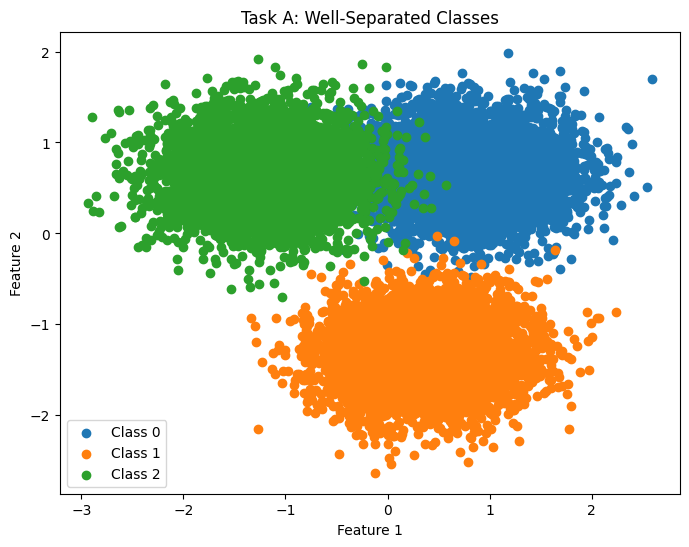

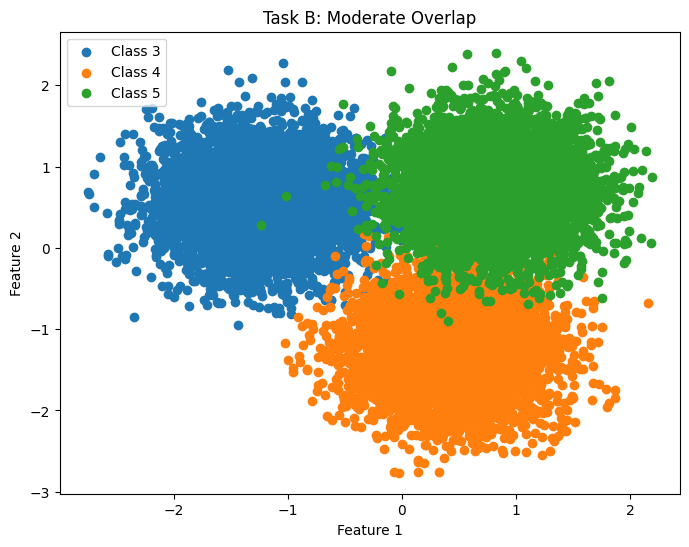

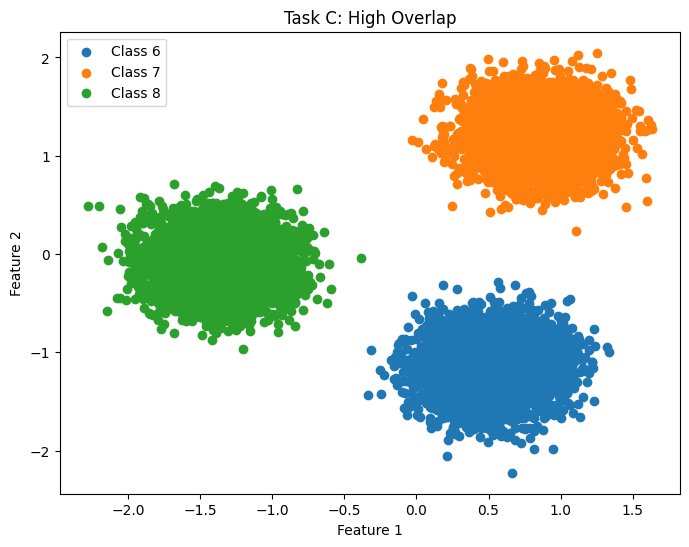

In [6]:
import matplotlib.pyplot as plt

def plot_data(X, y, title):
    plt.figure(figsize=(8, 6))
    for class_idx in np.unique(y):
        plt.scatter(X[y == class_idx, 0], X[y == class_idx, 1], label=f'Class {class_idx}')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# Visualize Task A
plot_data(X_A, y_A, "Task A: Well-Separated Classes")

# Visualize Task B
plot_data(X_B, y_B, "Task B: Moderate Overlap")

# Visualize Task C
plot_data(X_C, y_C, "Task C: High Overlap")


In [28]:
import torch
import torch.nn as nn

class EnhancedNeuralNet(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=32, output_dim=12):
        super(EnhancedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)   # Input to first hidden layer
        self.bn1 = nn.BatchNorm1d(hidden_dim)        # Batch normalization
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # Second hidden layer
        self.bn2 = nn.BatchNorm1d(hidden_dim)        # Batch normalization
        self.fc3 = nn.Linear(hidden_dim, output_dim) # Output layer
        self.dropout = nn.Dropout(0.35)               # Slightly higher dropout

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)  # Output logits for classification
        return x


In [29]:
import torch.nn as nn

class RegressionNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, output_dim=1):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc3(x)
        return x


In [30]:
class SimpleNeuralNet(nn.Module):
    def __init__(self):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(1, 10)  # Input dimension is 1 (sine value)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)  # Output dimension is 1 (sine value prediction)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [20]:
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score
import numpy as np
import torch.nn.functional as F

In [31]:
# Training and Evaluation Functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score

# Define training, evaluation, and EWC functions
def evaluate(model, loader, criterion):
    """
    Evaluate the model's performance on a Gaussian distribution point classification task.

    Args:
        model: The model to evaluate.
        loader: DataLoader providing input data and target labels.
        criterion: Loss function used for evaluation.

    Returns:
        dict: Dictionary containing evaluation metrics (loss, accuracy, precision, recall, kappa).
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in loader:
            output = model(data)  # Get raw logits
            loss = criterion(output, target)  # Calculate loss
            total_loss += loss.item()
            
            # Convert logits to probabilities
            probabilities = torch.softmax(output, dim=1)
            
            # Get predicted class as the one with the maximum probability
            preds = torch.argmax(probabilities, dim=1)
            
            # Collect predictions and labels for metric calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted')
    kappa = cohen_kappa_score(all_labels, all_preds)
    
    return accuracy, precision, recall, kappa

def evaluate_regression(model, loader, criterion):
    model.eval()
    total_loss = 0
    total_mse = 0
    total_mae = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            total_loss += criterion(output, target).item()
            total_mse += torch.nn.functional.mse_loss(output, target).item()
            total_mae += torch.nn.functional.l1_loss(output, target).item()

    # Average metrics over the loader size
    total_loss /= len(loader)
    total_mse /= len(loader)
    total_mae /= len(loader)
    
    return total_mae, total_loss, total_mse



def train(model, loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            optimizer.zero_grad()

            # Reshape data to ensure it has the correct shape (batch_size, 2)
            data = data.view(-1, 2)
            
            # Forward pass through the model
            output = model(data)
            
            # Compute the loss using the output and target (do not pass target to the model)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(loader)}')


In [32]:
def evaluate_old(model, test_loader, criterion):
    """
    Evaluate the model on the test dataset using CrossEntropyLoss.

    Args:
        model: Neural network being evaluated.
        test_loader: DataLoader containing the test dataset.
        criterion: Loss function (CrossEntropyLoss).

    Returns:
        Tuple containing accuracy, precision, recall, and kappa score.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            # Ensure data is of correct type
            data = data.to(torch.float32)

            # Forward pass
            outputs = model(data)

            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # Get predictions (argmax for class with highest score)
            _, preds = torch.max(outputs, 1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

            # Append to lists for metric computation
            all_targets.extend(targets.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute evaluation metrics
    accuracy = correct / total if total > 0 else 0.0
    precision = precision_score(all_targets, all_preds, average="weighted", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="weighted", zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_preds)

    return accuracy, precision, recall, kappa




from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score

def evaluate_binary(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in loader:
            data = data.view(-1, 1)  # Ensure input shape is [batch_size, 1]
            target = target.view(-1, 1)  # Ensure target shape is [batch_size, 1]

            # Forward pass
            logits = model(data)
            loss = criterion(logits, target)
            total_loss += loss.item()

            # Apply sigmoid and threshold at 0.5 for binary predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_preds)

    return accuracy, precision, recall, kappa



In [33]:
class EWC:
    def __init__(self, model, dataloader, importance=1000, fisher_decay=0.9):
        self.model = model
        self.dataloader = dataloader
        self.importance = importance
        self.fisher_decay = fisher_decay
        self.initial_params = {n: p.clone() for n, p in self.model.named_parameters()}
        self.fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}

    def compute_fisher_information(self):
        """
        Online calculation of Fisher information, updating existing values
        with a decay factor to account for older tasks.
        """
        new_fisher = {n: torch.zeros_like(p) for n, p in self.model.named_parameters()}
        self.model.eval()
        for data, target in self.dataloader:
            self.model.zero_grad()
            output = self.model(data.view(-1, 1))
            loss = F.binary_cross_entropy_with_logits(output, target)  # Use BCE loss for binary classification
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    new_fisher[n] += p.grad ** 2 / len(self.dataloader)

        # Update the Fisher diagonal with decay for online adjustment
        for n in self.fisher_diagonal:
            self.fisher_diagonal[n] = self.fisher_decay * self.fisher_diagonal[n] + new_fisher[n]

    def penalty(self):
        penalty = 0
        for n, p in self.model.named_parameters():
            penalty += (self.fisher_diagonal[n] * (p - self.initial_params[n]) ** 2).sum()
        return self.importance * penalty


In [34]:
class OnlineEWC:
    def __init__(self, model, dataloader):
        """
        Online EWC implementation for binary classification.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.fisher_matrix = {}
        self.optimal_params = {}

    def update_fisher_matrix(self):
        """
        Update the Fisher matrix for multi-class classification using CrossEntropyLoss.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
    
        for i, (data, target) in enumerate(self.dataloader, 1):
            # Prepare data and targets
            data = data.view(-1, self.model.fc1.in_features)
            target = target.long()  # Ensure targets are integers for CrossEntropyLoss
            
            self.model.zero_grad()
    
            # Forward pass
            output = self.model(data)
    
            # Use CrossEntropyLoss for multi-class classification
            loss = F.cross_entropy(output, target)
            loss.backward()
    
            # Accumulate Fisher information
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Normalize Fisher diagonal
        for n in fisher_diagonal:
            if n in self.fisher_matrix:
                self.fisher_matrix[n] += fisher_diagonal[n]
            else:
                self.fisher_matrix[n] = fisher_diagonal[n] / fisher_diagonal[n].sum() + 1e-8





    def store_optimal_params(self):
        """
        Store a copy of the model's current parameters as the optimal parameters for the current task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the EWC penalty based on the Fisher matrix and optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.fisher_matrix:
                penalty += (self.fisher_matrix[n] * (p - self.optimal_params[n]) ** 2).sum()
        return penalty


In [35]:
import torch.nn as nn
class OnlineEWCRegression:
    def __init__(self, model, dataloader):
        """
        Online EWC implementation for binary classification.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.fisher_matrix = {}
        self.optimal_params = {}

    def update_fisher_matrix(self):
        """
        Update the Fisher matrix for multi-class classification using CrossEntropyLoss.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
    
        for i, (data, target) in enumerate(self.dataloader, 1):          
            self.model.zero_grad()
            # Forward pass
            output = self.model(data)
            loss = F.smooth_l1_loss(output, target)
            loss.backward()
    
            # Accumulate Fisher information
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Normalize Fisher diagonal
        for n in fisher_diagonal:
            if n in self.fisher_matrix:
                self.fisher_matrix[n] += fisher_diagonal[n]
            else:
                self.fisher_matrix[n] = fisher_diagonal[n] / fisher_diagonal[n].sum() + 1e-8





    def store_optimal_params(self):
        """
        Store a copy of the model's current parameters as the optimal parameters for the current task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Calculate the EWC penalty based on the Fisher matrix and optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.fisher_matrix:
                penalty += (self.fisher_matrix[n] * (p - self.optimal_params[n]) ** 2).sum()
        return penalty


In [272]:
class SynapticIntelligence:
    def __init__(self, model, dataloader, importance=1000):
        """
        Synaptic Intelligence (SI) regularization.

        Args:
            model: The neural network model.
            dataloader: DataLoader for the task.
            importance: Weighting factor for the regularization penalty.
        """
        self.model = model
        self.dataloader = dataloader
        self.importance = importance

        # Store initial parameters and omega values
        self.initial_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}
        self.omega = {n: torch.zeros_like(p, requires_grad=False) for n, p in self.model.named_parameters() if p.requires_grad}

        # Store updates for parameter changes
        self.parameter_updates = {n: torch.zeros_like(p, requires_grad=False) for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        self.model.eval()
        for data, target in self.dataloader:
            self.model.zero_grad()
            output = self.model(data.view(data.size(0), -1))
            loss = F.binary_cross_entropy_with_logits(output, target)
            loss.backward()
    
            for n, p in self.model.named_parameters():
                if p.requires_grad and p.grad is not None:
                    delta = p.detach() - self.initial_params[n]
                    self.omega[n] += delta * p.grad.detach()
    
        # Normalize omega
        num_samples = len(self.dataloader.dataset)
        for n in self.omega:
            self.omega[n] /= num_samples
    
        # Update `initial_params` dynamically
        self.initial_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}



    def penalty(self):
        """
        Compute the SI regularization penalty.

        Returns:
            A scalar penalty value.
        """
        penalty = 0
        for n, p in self.model.named_parameters():
            if p.requires_grad:
                delta = p - self.initial_params[n]
                penalty += (self.omega[n] * delta ** 2).sum()
        return self.importance * penalty


In [387]:
class SynapticIntelligenceRegression:
    def __init__(self, model, dataloader):
        """
        Synaptic Intelligence (SI) implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.omega = {}
        self.optimal_params = {}

        # Initialize omega and optimal_params
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset omega and optimal_params to match the current model's parameters.
        """
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        
        dataset_size = len(self.dataloader.dataset)  # Normalize by dataset size
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            loss = F.mse_loss(output, target)  # Use MSE loss for regression
            loss.backward()
            
            # Accumulate squared gradients
            for n, p in self.model.named_parameters():
                if p.grad is not None and p.requires_grad:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Normalize and update Omega
        for n in fisher_diagonal:
            if n in self.omega:
                self.omega[n] += fisher_diagonal[n] / dataset_size  # Normalize by dataset size
            else:
                self.omega[n] = fisher_diagonal[n] / dataset_size
    
        # Log Omega stats
        omega_stats = {n: (self.omega[n].max().item(), self.omega[n].min().item()) for n in self.omega}

    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.omega and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                term = (self.omega[n] * diff ** 2).sum()
                penalty += term
        return penalty

In [274]:
def train_with_si(model, optimizer, dataloaders, si=None, lambda_si=0.1, epochs=5):
    """
    Train the model with or without SI penalty.

    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        si: Instance of the SynapticIntelligence class, or None if not using SI.
        lambda_si: Importance of the SI penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Add SI penalty if applicable
            if si is not None:
                si_penalty = si.penalty(model)
                loss += lambda_si * si_penalty
                total_penalty += si_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


In [348]:
def train_with_si_regression(model, optimizer, dataloaders, si=None, lambda_si=0.1, epochs=5):
    """
    Train the model with or without SI penalty.

    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        si: Instance of the SynapticIntelligence class, or None if not using SI.
        lambda_si: Importance of the SI penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = torch.nn.SmoothL1Loss()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_penalty = 0.0

        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Add SI penalty if applicable
            if si is not None:
                si_penalty = si.penalty(model)
                loss += lambda_si * si_penalty
                total_penalty += si_penalty.item()

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Log losses
        avg_loss = running_loss / len(dataloaders['train'])
        avg_penalty = total_penalty / len(dataloaders['train'])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Penalty: {avg_penalty:.4f}")


In [276]:
class SynapticIntelligence:
    def __init__(self, model, dataloader):
        """
        Synaptic Intelligence (SI) implementation.
        Args:
            model: Neural network model.
            dataloader: DataLoader for the current task.
        """
        self.model = model
        self.dataloader = dataloader
        self.omega = {}
        self.optimal_params = {}

        # Initialize omega and optimal_params
        self._initialize_params()

    def _initialize_params(self):
        """
        Initialize or reset omega and optimal_params to match the current model's parameters.
        """
        self.omega = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def update_omega(self):
        """
        Update the Omega matrix using the online method.
        """
        self.model.eval()
        fisher_diagonal = {n: torch.zeros_like(p) for n, p in self.model.named_parameters() if p.requires_grad}
    
        for i, (data, target) in enumerate(self.dataloader, 1):
            self.model.zero_grad()
            output = self.model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
    
            # Update Omega with squared gradients
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher_diagonal[n] += (p.grad ** 2 - fisher_diagonal[n]) / i
    
        # Normalize and assign to omega
        for n in fisher_diagonal:
            if n in self.omega:
                self.omega[n] += fisher_diagonal[n] / len(self.dataloader)  # Normalize by dataset size
            else:
                self.omega[n] = fisher_diagonal[n] / len(self.dataloader)
    
        # Log max and min values of omega for debugging
        print(f"Max omega: {max([v.max().item() for v in self.omega.values()])}")
        print(f"Min omega: {min([v.min().item() for v in self.omega.values()])}")



    def store_optimal_params(self):
        """
        Store the current model parameters as the optimal parameters after training a task.
        """
        self.optimal_params = {n: p.clone().detach() for n, p in self.model.named_parameters() if p.requires_grad}

    def penalty(self, model):
        """
        Compute the SI penalty based on the Omega matrix and stored optimal parameters.
        """
        penalty = 0.0
        for n, p in model.named_parameters():
            if n in self.omega and n in self.optimal_params:
                diff = p - self.optimal_params[n]
                term = (self.omega[n] * diff ** 2).sum()
                penalty += term
    
        # Debug the penalty value
        #print(f"Penalty: {penalty.item():.6f}")
        return penalty



In [471]:
class RehearsalBuffer:
    def __init__(self, buffer_size=200):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_to_buffer(self, data, target):
        for i in range(len(data)):
            if len(self.buffer) >= self.buffer_size:
                self.buffer.pop(0)
            self.buffer.append((data[i], target[i]))

    def get_buffer(self):
        data, target = zip(*self.buffer)
        return torch.stack(data), torch.tensor(target)

    def __len__(self):
        # Return the number of items currently in the buffer
        return len(self.buffer)

In [513]:
def train_with_rehearsal(model, dataloader, rehearsal_buffer, optimizer, criterion, epochs=1):
    """
    Train the model with rehearsal learning using a rehearsal buffer for regression tasks.

    Args:
        model: The neural network model.
        dataloader: DataLoader for the current task.
        rehearsal_buffer: RehearsalBuffer instance for storing and retrieving rehearsal data.
        optimizer: Optimizer for the model.
        criterion: Loss function (e.g., SmoothL1Loss or MSELoss).
        epochs: Number of epochs to train.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0

        for data, target in dataloader:
            # Ensure data and target are floats
            data = data.float()
            target = target.float()

            # Add rehearsal data
            if len(rehearsal_buffer) > 0:
                rehearsal_data, rehearsal_target = rehearsal_buffer.get_buffer()
                rehearsal_data = rehearsal_data.float()
                rehearsal_target = rehearsal_target.float()

                # Ensure shapes match
                rehearsal_target = rehearsal_target.view(-1, 1)  # Reshape if necessary
                target = target.view(-1, 1)  # Reshape if necessary

                # Concatenate data and targets
                data = torch.cat((data, rehearsal_data))
                target = torch.cat((target, rehearsal_target))

            # Forward pass
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Add current batch to the rehearsal buffer
            rehearsal_buffer.add_to_buffer(data.detach().cpu(), target.detach().cpu())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")


In [354]:
def train_with_rehearsal_regression(model, loader_new, loader_replay, optimizer, criterion, epochs=10, replay_ratio=0.5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0  # Track the number of batches for accurate averaging
        for data_new, target_new in loader_new:
            if random.random() < replay_ratio:
                data_replay, target_replay = next(iter(loader_replay))
                data, target = torch.cat([data_new, data_replay]), torch.cat([target_new, target_replay])
            else:
                data, target = data_new, target_new
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        
        # Print loss once per epoch
        avg_loss = total_loss / batch_count
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}')


In [279]:
epoch_stats_other = {
    "si": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[]},
    "pnn": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[]},
    "reh": {"accuracy": [], "loss": [], "task_A_during_B":[],"task_B_during_C":[],"task_A_during_C":[],"task_B":[], "val_task_A_during_B":[],"val_task_B_during_C":[],"val_task_A_during_C":[],"val_task_B":[],"task_C":[],"val_task_C":[],"A_during_A":[],"B_during_A":[],"C_during_A":[],"C_during_B":[],"A_during_A_val":[],"B_during_A_val":[],"C_during_A_val":[],"C_during_B_val":[]}
}

In [416]:
num_runs = 10
epochs = 100
importance = 10000000
learning_rate = 0.0001
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize the model for SI
    model_si = SimpleNeuralNet()
    
    optimizer_si = optim.Adam(model_si.parameters(), lr=learning_rate)
    #scheduler = optim.lr_scheduler.StepLR(optimizer_si, step_size=5, gamma=0.5)  # Reduce LR over epochs


    A_during_A = []
    B_during_A = []
    C_during_A = []
    C_during_B = []

    A_during_A_val = []
    B_during_A_val = []
    C_during_A_val = []
    C_during_B_val = []
    
    si = SynapticIntelligenceRegression(model_si, train_loader_1)
    
    # Train on Task 1
    for epoch in range(epochs):
        train_with_si_regression(model_si, optimizer_si, {'train': train_loader_1, 'val': val_loader_1}, si=None, lambda_si=0, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si, _, _= evaluate_regression(model_si, test_loader_1, criterion)
        A_during_A.append(accuracy_taskA_during_si)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _= evaluate_regression(model_si, test_loader_2, criterion)
        B_during_A.append(B_during_A_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc, _, _= evaluate_regression(model_si, test_loader_3, criterion)
        C_during_A.append(C_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _= evaluate_regression(model_si, val_loader_1, criterion)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _= evaluate_regression(model_si, val_loader_2, criterion)
        B_during_A_val.append(B_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc_val, _, _= evaluate_regression(model_si, val_loader_3, criterion)
        C_during_A_val.append(C_during_A_acc_val)

    epoch_stats_other["si"]["A_during_A"].append(A_during_A)
    epoch_stats_other["si"]["B_during_A"].append(B_during_A)
    epoch_stats_other["si"]["C_during_A"].append(C_during_A)
    epoch_stats_other["si"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["si"]["B_during_A_val"].append(B_during_A_val)
    epoch_stats_other["si"]["C_during_A_val"].append(C_during_A_val)
    
    metrics_task1_initial_si = evaluate_regression(model_si, test_loader_1, criterion)
    print(f"Task 1 - Initial with SI: {metrics_task1_initial_si}")

    metrics_task1_initial_si_val = evaluate_regression(model_si, val_loader_1, criterion)
    print(f"Task 1 - Initial with SI - validation: {metrics_task1_initial_si_val}")

    task_A_during_B_si_run = []
    val_A_during_B_si_run = []
    
    task_A_during_C_si_run = []
    val_A_during_C_si_run = []

    task_B_during_C_si_run = []
    val_B_during_C_si_run = []
    
    task_B_si_run = []
    val_B_si_run = []

    task_C_si_run = []
    val_C_si_run = []

    
    si.update_omega()
    si.store_optimal_params()
    
    # Train on Task 2 with SI

    # Train on Task 1
    for epoch in range(epochs):
        train_with_si_regression(model_si, optimizer_si, {'train': train_loader_2, 'val': val_loader_2}, si=si, lambda_si=9000000, epochs=1)
    
        # Evaluate on test set for Domain B
        accuracy_taskB_during_si, _, _= evaluate_regression(model_si, test_loader_2, criterion)
        task_B_si_run.append(accuracy_taskB_during_si)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_si_val, _, _= evaluate_regression(model_si, val_loader_2, criterion)
        val_B_si_run.append(accuracy_taskB_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_si, _, _= evaluate_regression(model_si, test_loader_1, criterion)
        task_A_during_B_si_run.append(accuracy_A_during_taskB_during_si)

        accuracy_A_during_taskB_during_si_val, _, _= evaluate_regression(model_si, val_loader_1, criterion)
        val_A_during_B_si_run.append(accuracy_A_during_taskB_during_si_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc, _, _= evaluate_regression(model_si, test_loader_3, criterion)
        C_during_B.append(C_during_B_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc_val, _, _= evaluate_regression(model_si, val_loader_3, criterion)
        C_during_B_val.append(C_during_B_acc_val)

    epoch_stats_other["si"]["task_A_during_B"].append(task_A_during_B_si_run)
    epoch_stats_other["si"]["task_B"].append(task_B_si_run)
    epoch_stats_other["si"]["C_during_B"].append(C_during_B)
    
    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_B"].append(val_A_during_B_si_run)
    epoch_stats_other["si"]["val_task_B"].append(val_B_si_run)
    epoch_stats_other["si"]["C_during_B_val"].append(C_during_B_val)
    
    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si = evaluate_regression(model_si, test_loader_1, criterion)
    print(f"Task 1 after Task 2 with SI: {metrics_task1_after_2_si}")

    # Evaluate on Task 1 after training on Task 2 with SI
    metrics_task1_after_2_si_val = evaluate_regression(model_si, val_loader_1, criterion)
    print(f"Task 1 after Task 2 with SI - validation: {metrics_task1_after_2_si_val}")

    print("Evaluating on Task B with SI")
    accuracy_taskB_si, precision_taskB_si, recall_taskB_si = evaluate_regression(model_si, test_loader_2, criterion)
    accuracy_taskB_si_val, precision_taskB_si_val, recall_taskB_si_val = evaluate_regression(model_si, val_loader_2, criterion)

    si.update_omega()
    si.store_optimal_params()
    
    # Train on Task 3 with SI
    for epoch in range(epochs):
        train_with_si_regression(model_si, optimizer_si, {'train': train_loader_3, 'val': val_loader_3}, si=si, lambda_si=9000000, epochs=1)
    
        # Evaluate on test set for Domain C
        accuracy_taskC_during_si, _, _= evaluate_regression(model_si, test_loader_3, criterion)
        task_C_si_run.append(accuracy_taskC_during_si)

        # Evaluate on validation set for Domain C
        accuracy_taskC_during_si_val, _, _= evaluate_regression(model_si, val_loader_3, criterion)
        val_C_si_run.append(accuracy_taskC_during_si_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskC_during_si, _, _= evaluate_regression(model_si, test_loader_1, criterion)
        task_A_during_C_si_run.append(accuracy_A_during_taskC_during_si)

        accuracy_A_during_taskC_during_si_val, _, _= evaluate_regression(model_si, val_loader_1, criterion)
        val_A_during_C_si_run.append(accuracy_A_during_taskC_during_si_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskC_during_si, _, _= evaluate_regression(model_si, test_loader_2, criterion)
        task_B_during_C_si_run.append(accuracy_B_during_taskC_during_si)

        accuracy_B_during_taskC_during_si_val, _, _= evaluate_regression(model_si, val_loader_2, criterion)
        val_B_during_C_si_run.append(accuracy_B_during_taskC_during_si_val)

        # Step the scheduler
        #scheduler.step()
    
        # Print learning rate
        #current_lr = scheduler.get_last_lr()[0]
        #print(f"Epoch {epoch + 1}/{epochs}, Learning Rate: {current_lr:.6f}")

    epoch_stats_other["si"]["task_A_during_C"].append(task_A_during_C_si_run)
    epoch_stats_other["si"]["task_C"].append(task_C_si_run)

    # Store validation metrics for each run
    epoch_stats_other["si"]["val_task_A_during_C"].append(val_A_during_C_si_run)
    epoch_stats_other["si"]["val_task_C"].append(val_C_si_run)

    epoch_stats_other["si"]["task_B_during_C"].append(task_B_during_C_si_run)
    epoch_stats_other["si"]["val_task_B_during_C"].append(val_B_during_C_si_run)
    
    metrics_task3_si = evaluate_regression(model_si, test_loader_3, criterion)
    print(f"Task 3 with SI: {metrics_task3_si}")

    metrics_task3_si_val = evaluate_regression(model_si, val_loader_3, criterion)
    print(f"Task 3 with SI - validation: {metrics_task3_si_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_3_si = evaluate_regression(model_si, test_loader_1, criterion)
    metrics_task2_after_3_si = evaluate_regression(model_si, test_loader_2, criterion)
    print(f"Task 1 after Task 3 with SI: {metrics_task1_after_3_si}")
    print(f"Task 2 after Task 3 with SI: {metrics_task2_after_3_si}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with SI
    metrics_task1_after_3_si_val = evaluate_regression(model_si, val_loader_1, criterion)
    metrics_task2_after_3_si_val = evaluate_regression(model_si, val_loader_2, criterion)
    print(f"Task 1 after Task 3 with SI - validation: {metrics_task1_after_3_si_val}")
    print(f"Task 2 after Task 3 with SI - validation: {metrics_task2_after_3_si_val}")

    #with open('epoch_stats_other_cil_toy_si.json', 'w') as f:
        #json.dump(epoch_stats_other, f, indent=4)


Run 1/10
Epoch 1/1, Loss: 0.2155, Penalty: 0.0000
Epoch 1/1, Loss: 0.1591, Penalty: 0.0000
Epoch 1/1, Loss: 0.1425, Penalty: 0.0000
Epoch 1/1, Loss: 0.1144, Penalty: 0.0000
Epoch 1/1, Loss: 0.0906, Penalty: 0.0000
Epoch 1/1, Loss: 0.0757, Penalty: 0.0000
Epoch 1/1, Loss: 0.0637, Penalty: 0.0000
Epoch 1/1, Loss: 0.0545, Penalty: 0.0000
Epoch 1/1, Loss: 0.0476, Penalty: 0.0000
Epoch 1/1, Loss: 0.0427, Penalty: 0.0000
Epoch 1/1, Loss: 0.0390, Penalty: 0.0000
Epoch 1/1, Loss: 0.0361, Penalty: 0.0000
Epoch 1/1, Loss: 0.0336, Penalty: 0.0000
Epoch 1/1, Loss: 0.0313, Penalty: 0.0000
Epoch 1/1, Loss: 0.0292, Penalty: 0.0000
Epoch 1/1, Loss: 0.0273, Penalty: 0.0000
Epoch 1/1, Loss: 0.0255, Penalty: 0.0000
Epoch 1/1, Loss: 0.0239, Penalty: 0.0000
Epoch 1/1, Loss: 0.0218, Penalty: 0.0000
Epoch 1/1, Loss: 0.0173, Penalty: 0.0000
Epoch 1/1, Loss: 0.0157, Penalty: 0.0000
Epoch 1/1, Loss: 0.0144, Penalty: 0.0000
Epoch 1/1, Loss: 0.0133, Penalty: 0.0000
Epoch 1/1, Loss: 0.0123, Penalty: 0.0000
Epoch 1

In [469]:
with open('epoch_stats_other_cil_toy_si_regression.json', 'w') as f:
        json.dump(epoch_stats_other, f, indent=4)

In [415]:
for key in epoch_stats_other["si"]:
    epoch_stats_other["si"][key] = []

In [554]:
for key in epoch_stats_other["reh"]:
    epoch_stats_other["reh"][key] = []

In [555]:
num_runs = 10
epochs = 100
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    

    # Initialize the model for Rehearsal
    print("beginning")

    model_rehearsal = SimpleNeuralNet()
    optimizer_rehearsal = optim.Adam(model_rehearsal.parameters(), lr=learning_rate)
    print("Model initialised")
    # Initialize Rehearsal Buffer
    rehearsal_buffer = RehearsalBuffer(buffer_size=50)
    print("Buffer obtained")

    A_during_A = []
    B_during_A = []
    C_during_A = []
    C_during_B = []

    A_during_A_val = []
    B_during_A_val = []
    C_during_A_val = []    
    C_during_B_val = []
    
    
    # Train on Task 1 with Rehearsal
    for epoch in range(epochs):
        #train_with_rehearsal(model_rehearsal, train_loader_1, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)
        train_with_rehearsal(model_rehearsal, train_loader_1, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_reh, _, _, = evaluate_regression(model_rehearsal, test_loader_1, criterion)
        A_during_A.append(accuracy_taskA_during_reh)

        # Evaluate on validation set for Domain B
        B_during_A_acc, _, _, = evaluate_regression(model_rehearsal, test_loader_2, criterion)
        B_during_A.append(B_during_A_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc, _, _, = evaluate_regression(model_rehearsal, test_loader_3, criterion)
        C_during_A.append(C_during_A_acc)

        # Evaluate on test set for Domain B
        accuracy_taskA_during_si_val, _, _, = evaluate_regression(model_rehearsal, val_loader_1, criterion)
        A_during_A_val.append(accuracy_taskA_during_si_val)

        # Evaluate on validation set for Domain B
        B_during_A_acc_val, _, _, = evaluate_regression(model_rehearsal, val_loader_2, criterion)
        B_during_A_val.append(B_during_A_acc_val)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_A_acc_val, _, _, = evaluate_regression(model_rehearsal, val_loader_3, criterion)
        C_during_A_val.append(C_during_A_acc_val)

    epoch_stats_other["reh"]["A_during_A"].append(A_during_A)
    epoch_stats_other["reh"]["B_during_A"].append(B_during_A)
    epoch_stats_other["reh"]["C_during_A"].append(C_during_A)
    epoch_stats_other["reh"]["A_during_A_val"].append(A_during_A_val)
    epoch_stats_other["reh"]["B_during_A_val"].append(B_during_A_val)
    epoch_stats_other["reh"]["C_during_A_val"].append(C_during_A_val)

    
    metrics_task1_initial_rehearsal = evaluate_regression(model_rehearsal, test_loader_1, criterion)
    print(f"Task 1 - Initial with Rehearsal: {metrics_task1_initial_rehearsal}")

    metrics_task1_initial_reh_val = evaluate_regression(model_rehearsal, val_loader_1, criterion)
    print(f"Task 1 - Initial with Rehearsal - validation: {metrics_task1_initial_reh_val}")

    task_A_during_B_reh_run = []
    val_A_during_B_reh_run = []
    
    task_A_during_C_reh_run = []
    val_A_during_C_reh_run = []

    task_B_during_C_reh_run = []
    val_B_during_C_reh_run = []
    
    task_B_reh_run = []
    val_B_reh_run = []

    task_C_reh_run = []
    val_C_reh_run = []
    
    # Train on Task 2 with Rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_2, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)
        #train_with_rehearsal(model_rehearsal, train_loader_2, train_loader_1, optimizer_rehearsal, criterion, epochs=1, replay_ratio=0.5)
        
        # Evaluate on test set for Domain B
        accuracy_taskB_during_reh, _, _, = evaluate_regression(model_rehearsal, test_loader_2, criterion)
        task_B_reh_run.append(accuracy_taskB_during_reh)

        # Evaluate on validation set for Domain B
        accuracy_taskB_during_reh_val, _, _, = evaluate_regression(model_rehearsal, val_loader_2, criterion)
        val_B_reh_run.append(accuracy_taskB_during_reh_val)
        print(f"Class B during Class B with reh - validation: {accuracy_taskB_during_reh_val}")

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        accuracy_A_during_taskB_during_reh, _, _, = evaluate_regression(model_rehearsal, test_loader_1, criterion)
        task_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh)
        

        accuracy_A_during_taskB_during_reh_val, _, _, = evaluate_regression(model_rehearsal, val_loader_1, criterion)
        val_A_during_B_reh_run.append(accuracy_A_during_taskB_during_reh_val)

        print(f"Class A during Class B with reh - validation: {accuracy_A_during_taskB_during_reh_val}")

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc, _, _, = evaluate_regression(model_rehearsal, test_loader_3, criterion)
        C_during_B.append(C_during_B_acc)

        # Evaluate performance on Domain A during training on Domain B (test and validation)
        C_during_B_acc_val, _, _, = evaluate_regression(model_rehearsal, val_loader_3, criterion)
        C_during_B_val.append(C_during_B_acc_val)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["C_during_B_val"].append(C_during_B_val)
    epoch_stats_other["reh"]["C_during_B"].append(C_during_B)

    epoch_stats_other["reh"]["task_A_during_B"].append(task_A_during_B_reh_run)
    epoch_stats_other["reh"]["task_B"].append(task_B_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_B"].append(val_A_during_B_reh_run)
    epoch_stats_other["reh"]["val_task_B"].append(val_B_reh_run)
    
    # Evaluate on Task 1 after training on Task 2 with reh
    metrics_task1_after_2_reh_val = evaluate_regression(model_rehearsal, val_loader_1, criterion)
    print(f"Task 1 after Task 2 with reh - validation: {metrics_task1_after_2_reh_val}")

    print("Evaluating on Task B with reh")
    accuracy_taskB_reh, precirehon_taskB_reh, recall_taskB_reh = evaluate_regression(model_rehearsal, test_loader_2, criterion)
    accuracy_taskB_reh_val, precirehon_taskB_reh_val, recall_taskB_reh_val = evaluate_regression(model_rehearsal, val_loader_2, criterion)
    
    # Train on Task 3 with Rehearsal
    for epoch in range(epochs):
        train_with_rehearsal(model_rehearsal, train_loader_3, rehearsal_buffer, optimizer_rehearsal, criterion, epochs=1)
        
        # Evaluate on test set for Domain C
        accuracy_taskC_during_reh, _, _, = evaluate_regression(model_rehearsal, test_loader_3, criterion)
        task_C_reh_run.append(accuracy_taskC_during_reh)

        # Evaluate on validation set for Domain C
        accuracy_taskC_during_reh_val, _, _, = evaluate_regression(model_rehearsal, val_loader_3, criterion)
        val_C_reh_run.append(accuracy_taskC_during_reh_val)

        # Evaluate performance on Domain A during training on Domain C (test and validation)
        accuracy_A_during_taskC_during_reh, _, _, = evaluate_regression(model_rehearsal, test_loader_1, criterion)
        task_A_during_C_reh_run.append(accuracy_A_during_taskC_during_reh)

        accuracy_A_during_taskC_during_reh_val, _, _, = evaluate_regression(model_rehearsal, val_loader_1, criterion)
        val_A_during_C_reh_run.append(accuracy_A_during_taskC_during_reh_val)

        # Evaluate performance on Domain B during training on Domain C (test and validation)
        accuracy_B_during_taskC_during_reh, _, _, = evaluate_regression(model_rehearsal, test_loader_2, criterion)
        task_B_during_C_reh_run.append(accuracy_B_during_taskC_during_reh)

        accuracy_B_during_taskC_during_reh_val, _, _, = evaluate_regression(model_rehearsal, val_loader_2, criterion)
        val_B_during_C_reh_run.append(accuracy_B_during_taskC_during_reh_val)
        print(f"Class A during Class C with reh - validation: {accuracy_A_during_taskB_during_reh_val}")
        print(f"Class B during Class C with reh - validation: {accuracy_A_during_taskC_during_reh_val}")
        print(f"Class C during Class C with reh - validation: {accuracy_taskC_during_reh_val}")

    epoch_stats_other["reh"]["task_A_during_C"].append(task_A_during_C_reh_run)
    epoch_stats_other["reh"]["task_C"].append(task_C_reh_run)

    # Store validation metrics for each run
    epoch_stats_other["reh"]["val_task_A_during_C"].append(val_A_during_C_reh_run)
    epoch_stats_other["reh"]["val_task_C"].append(val_C_reh_run)

    epoch_stats_other["reh"]["task_B_during_C"].append(task_B_during_C_reh_run)
    epoch_stats_other["reh"]["val_task_B_during_C"].append(val_B_during_C_reh_run)
    
    metrics_task3_reh = evaluate_regression(model_rehearsal, test_loader_3, criterion)
    print(f"Task 3 with reh: {metrics_task3_reh}")

    metrics_task3_reh_val = evaluate_regression(model_rehearsal, val_loader_3, criterion)
    print(f"Task 3 with reh - validation: {metrics_task3_reh_val}")
    
    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_3_reh = evaluate_regression(model_rehearsal, test_loader_1, criterion)
    metrics_task2_after_3_reh = evaluate_regression(model_rehearsal, test_loader_2, criterion)
    print(f"Task 1 after Task 3 with reh: {metrics_task1_after_3_reh}")
    print(f"Task 2 after Task 3 with reh: {metrics_task2_after_3_reh}")

    # Evaluate on Task 1 and Task 2 after training on Task 3 with reh
    metrics_task1_after_3_reh_val = evaluate_regression(model_rehearsal, val_loader_1, criterion)
    metrics_task2_after_3_reh_val = evaluate_regression(model_rehearsal, val_loader_2, criterion)
    print(f"Task 1 after Task 3 with reh - validation: {metrics_task1_after_3_reh_val}")
    print(f"Task 2 after Task 3 with reh - validation: {metrics_task2_after_3_reh_val}")

    # with open('epoch_stats_other_cil_toy_regression_reh_2000.json', 'w') as f:
    #     json.dump(epoch_stats_other, f, indent=4)



Run 1/10
beginning
Model initialised
Buffer obtained
Epoch 1/1, Loss: 0.1479
Epoch 1/1, Loss: 0.1050
Epoch 1/1, Loss: 0.0775
Epoch 1/1, Loss: 0.0585
Epoch 1/1, Loss: 0.0457
Epoch 1/1, Loss: 0.0381
Epoch 1/1, Loss: 0.0338
Epoch 1/1, Loss: 0.0310
Epoch 1/1, Loss: 0.0290
Epoch 1/1, Loss: 0.0273
Epoch 1/1, Loss: 0.0257
Epoch 1/1, Loss: 0.0241
Epoch 1/1, Loss: 0.0226
Epoch 1/1, Loss: 0.0211
Epoch 1/1, Loss: 0.0196
Epoch 1/1, Loss: 0.0180
Epoch 1/1, Loss: 0.0165
Epoch 1/1, Loss: 0.0151
Epoch 1/1, Loss: 0.0137
Epoch 1/1, Loss: 0.0124
Epoch 1/1, Loss: 0.0112
Epoch 1/1, Loss: 0.0102
Epoch 1/1, Loss: 0.0092
Epoch 1/1, Loss: 0.0084
Epoch 1/1, Loss: 0.0077
Epoch 1/1, Loss: 0.0070
Epoch 1/1, Loss: 0.0065
Epoch 1/1, Loss: 0.0060
Epoch 1/1, Loss: 0.0057
Epoch 1/1, Loss: 0.0053
Epoch 1/1, Loss: 0.0050
Epoch 1/1, Loss: 0.0047
Epoch 1/1, Loss: 0.0045
Epoch 1/1, Loss: 0.0043
Epoch 1/1, Loss: 0.0041
Epoch 1/1, Loss: 0.0040
Epoch 1/1, Loss: 0.0038
Epoch 1/1, Loss: 0.0037
Epoch 1/1, Loss: 0.0036
Epoch 1/1, 

In [527]:
import json
with open('epoch_stats_other_cil_toy_regression_250Buffer.json', 'w') as f:
    json.dump(epoch_stats_other, f, indent=4)

In [516]:
import json
with open('epoch_stats_cil_toy_regression.json', 'w') as f:
    json.dump(epoch_stats, f, indent=4)

In [518]:
# Combining the two dictionaries
epoch_stats_other_reh_buffer_4000 = {}

for key in epoch_stats_other.keys():
    epoch_stats_other_reh_buffer_4000[key] = {}
    for sub_key in epoch_stats_other[key]:
        # Combine lists for each sub-key
        epoch_stats_other_reh_buffer_4000[key][sub_key] = epoch_stats_other[key][sub_key]
         



In [36]:
def train_with_ewc(model, optimizer, dataloaders, ewc=None, lambda_ewc=1e3, epochs=5):
    """
    Train the model using CrossEntropyLoss with optional EWC regularization.

    Args:
        model: Neural network being trained.
        optimizer: Optimizer for the model.
        dataloaders: Dictionary with 'train' and optionally 'val' DataLoaders.
        ewc: Elastic Weight Consolidation (optional).
        lambda_ewc: Regularization strength for EWC penalty.
        epochs: Number of training epochs.

    Returns:
        Trained model.
    """
    criterion = nn.CrossEntropyLoss()  # Multi-class classification loss

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data, targets in dataloaders['train']:
            # Check the input and target sizes
            #print(f"Batch data shape: {data.shape}, Batch target shape: {targets.shape}")

            # Flatten input and ensure correct target type
            batch_size = data.size(0)
            data = data.view(batch_size, -1)  # Ensure proper flattening
            targets = targets.long()  # Targets must be integers

            if data.size(0) != targets.size(0):
                raise ValueError(f"Mismatch: input batch size {data.size(0)} does not match target batch size {targets.size(0)}")

            optimizer.zero_grad()

            # Forward pass
            logits = model(data)
            loss = criterion(logits, targets)

            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty

            # Backward pass
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Compute accuracy
            _, preds = torch.max(logits, 1)  # Class with highest logit
            correct += (preds == targets).sum().item()
            total += targets.size(0)

        avg_loss = running_loss / len(dataloaders['train'])
        accuracy = correct / total if total > 0 else 0.0
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return model


In [156]:
epoch_stats_full = epoch_stats

In [37]:
def evaluate(model, test_loader, criterion, current_classes):
    """
    Evaluate the model on the given test_loader.

    Args:
        model: The neural network being evaluated.
        test_loader: DataLoader containing the test dataset.
        criterion: Loss function.
        current_classes: List of class indices relevant to the current task.

    Returns:
        Tuple containing accuracy, precision, recall, and kappa score.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct = 0
    total = 0

    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, targets in test_loader:
            data = data[:, :20]  # Select the first 10 features
            # Forward pass
            outputs = model(data)

            # Dynamically mask irrelevant outputs (only keep current task classes)
            outputs = outputs[:, current_classes]

            # Adjust targets to align with the current task's class indices
            task_targets = torch.tensor(
                [current_classes.index(t.item()) for t in targets if t.item() in current_classes]
            )

            # Compute loss
            loss = criterion(outputs, task_targets)
            total_loss += loss.item()

            # Get predictions
            _, preds = torch.max(outputs, 1)
            correct += (preds == task_targets).sum().item()
            total += task_targets.size(0)

            # Append to lists for metric computation
            all_targets.extend(task_targets.numpy())
            all_preds.extend(preds.numpy())

    # Compute evaluation metrics
    accuracy = correct / total if total > 0 else 0.0
    precision = precision_score(all_targets, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_targets, all_preds, average="macro", zero_division=0)
    kappa = cohen_kappa_score(all_targets, all_preds)

    return accuracy, precision, recall, kappa


In [38]:
print(f"Train set size (Class A): {len(train_dataset_1)}")
print(f"Validation set size (Class A): {len(val_dataset_1)}")
print(f"Test set size (Class A): {len(test_dataset_1)}")


Train set size (Class A): 14000
Validation set size (Class A): 3000
Test set size (Class A): 3000


In [39]:
def train_with_ewc_regression(model, optimizer, dataloaders, ewc=None, lambda_ewc=0.1, epochs=5):
    """
    Train the model with or without EWC penalty.
    
    Args:
        model: Neural network model to train.
        optimizer: Optimizer for training.
        dataloaders: Dictionary containing 'train' and optionally 'val' dataloaders.
        ewc: Instance of the EWC class, or None if not using EWC.
        lambda_ewc: Importance of the EWC penalty (default is 0.1).
        epochs: Number of epochs to train.
    """
    criterion = torch.nn.SmoothL1Loss()

    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, targets in dataloaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Add EWC penalty if applicable
            if ewc is not None:
                ewc_penalty = ewc.penalty(model)
                loss += lambda_ewc * ewc_penalty
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloaders['train'])}")

In [109]:
import numpy as np
import torch.optim as optim

# Hyperparameters
learning_rate = 0.0001
importance = 900000000000000
cil_toy_a_weights = []
input_dim = 8  # 2D Gaussian data
hidden_dim = 128  # Hidden layer size
output_dim = 9  # Number of classes for Task A


# Initialize storage for results
results = {
    "untrained_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []}
}

results_val = {
    "initial_A": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_B_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "A_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []},
    "B_after_C_no_ewc": {"accuracy": [], "precision": [], "recall": [], "kappa": []}
}

# Store per-epoch values for charting the training of Task 2 and Task 3
epoch_stats = {
    "Initial": {"A_during_A": [], "loss": [],"A_during_A_val": [],"B_during_A": [],"B_during_A_val": [],"C_during_A": [],"C_during_A_val": []},
    "ewc": {
        "accuracy": [], "loss": [], "task_A_during_B":[], "val_task_A_during_B": [], 
        "task_B_during_C": [], "task_A_during_C": [], "val_task_B_during_C": [], "val_task_A_during_C": [], "val_task_C_during_B": [], "task_C_during_B": [],
        "task_B": [], "task_C": [], "val_task_C": [],"val_task_B": []
    },
    "no_ewc": {
        "accuracy": [], "loss": [], "task_A_during_B": [], "val_task_A_during_B": [], 
        "task_B_during_C": [], "task_A_during_C": [], "val_task_B_during_C": [], "val_task_A_during_C": [], "val_task_C_during_B": [], "task_C_during_B": [],
        "task_B": [], "val_task_B": [], "task_C": [], "val_task_C": []
    }
}

# For multiple runs
num_runs = 10
epochs = 100
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Initialize model, optimizer, and criterion for Task A
    model_A = SimpleNeuralNet()

    optimizer_A = optim.Adam(model_A.parameters(), lr=learning_rate)
    criterion = torch.nn.SmoothL1Loss()

    # Step 2: Evaluate Task A untrained
    mae_untrained_A, precision_untrained_A, recall_untrained_A = evaluate_regression(model_A, val_loader_1, criterion)
    print(f"Task A - Untrained: Accuracy: {mae_untrained_A}, Precision: {precision_untrained_A}, Recall: {recall_untrained_A}")
    results["untrained_A"]["accuracy"].append(mae_untrained_A)
    results["untrained_A"]["precision"].append(precision_untrained_A)
    results["untrained_A"]["recall"].append(recall_untrained_A)

    
    task_A_during_A = []
    task_A_during_A_val = []

    task_B_during_A = []
    task_B_during_A_val = []

    task_C_during_A = []
    task_C_during_A_val = []

    ewc = OnlineEWCRegression(model_A, train_loader_1)
    #total_loss, total_mse, total_mae
    # Train model on Task A
    for epoch in range(epochs):
        train_with_ewc_regression(model_A, optimizer_A, {'train': train_loader_1, 'val': val_loader_1}, ewc=None, lambda_ewc=0, epochs=1)

        # Track performance on Task A
        mae_taskA_duringA, _, _= evaluate_regression(model_A, test_loader_1, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task A: {mae_taskA_duringA:.4f}")
        task_A_during_A.append(mae_taskA_duringA)

        # Track performance on Task A
        mae_taskB_duringA, _, _ = evaluate_regression(model_A, test_loader_2, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task A: {mae_taskB_duringA:.4f}")
        task_B_during_A.append(mae_taskB_duringA)


        # Track performance on Task A
        mae_taskC_duringA, _, _ = evaluate_regression(model_A, test_loader_3, criterion)
        print(f"Epoch {epoch + 1} - Task C performance during Task A: {mae_taskC_duringA:.4f}")
        task_C_during_A.append(mae_taskC_duringA)

        # Track performance on Task A
        mae_taskA_duringA_val, _, _ = evaluate_regression(model_A, val_loader_1, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task A - val: {mae_taskA_duringA_val:.4f}")
        task_A_during_A_val.append(mae_taskA_duringA_val)

        # Track performance on Task A
        mae_taskB_duringA_val, _, _ = evaluate_regression(model_A, val_loader_2, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task A - val: {mae_taskB_duringA_val:.4f}")
        task_B_during_A_val.append(mae_taskB_duringA_val)


        # Track performance on Task A
        mae_taskC_duringA_val, _, _ = evaluate_regression(model_A, val_loader_3, criterion)
        print(f"Epoch {epoch + 1} - Task C performance during Task A - val: {mae_taskC_duringA_val:.4f}")
        task_C_during_A_val.append(mae_taskC_duringA_val)


    epoch_stats["Initial"]["A_during_A"].append(task_A_during_A)
    epoch_stats["Initial"]["B_during_A"].append(task_B_during_A)
    epoch_stats["Initial"]["C_during_A"].append(task_C_during_A)

    epoch_stats["Initial"]["A_during_A_val"].append(task_A_during_A_val)
    epoch_stats["Initial"]["B_during_A_val"].append(task_B_during_A_val)
    epoch_stats["Initial"]["C_during_A_val"].append(task_C_during_A_val)

    torch.save(model_A.state_dict(), 'cil_toy_task_model.pth')
    #torch.save(model_A.state_dict(), 'cil_toy_task_model.pth')
    # Save model weights after Task A training


    ewc.update_fisher_matrix()
    ewc.store_optimal_params()

    # Step 2: Evaluate Task A trained
    # Evaluate initial performance on Task A
    mae_taskA_initial, precision_taskA_initial, recall_taskA_initial = evaluate_regression(model_A, test_loader_1, criterion)
    print(f"Task A - Initial: Accuracy: {mae_taskA_initial:.4f}, Precision: {precision_taskA_initial:.4f}, Recall: {recall_taskA_initial:.4f}")
    results["initial_A"]["accuracy"].append(mae_taskA_initial)
    results["initial_A"]["precision"].append(precision_taskA_initial)
    results["initial_A"]["recall"].append(recall_taskA_initial)

    mae_taskA_initial_val, precision_taskA_initial_val, recall_taskA_initial_val = evaluate_regression(model_A, val_loader_1, criterion)
    print(f"Task A - Initial: Accuracy: {mae_taskA_initial_val:.4f}, Precision: {precision_taskA_initial_val:.4f}, Recall: {recall_taskA_initial_val:.4f}")
    results_val["initial_A"]["accuracy"].append(mae_taskA_initial_val)
    results_val["initial_A"]["precision"].append(precision_taskA_initial_val)
    results_val["initial_A"]["recall"].append(recall_taskA_initial_val)

    # Store task_A_during_B as a list for this run
    task_A_during_B_ewc_run = []
    task_A_during_B_no_ewc_run = []
    task_A_during_C_ewc_run = []
    task_A_during_C_no_ewc_run = []
    task_B_during_C_ewc_run = []
    task_B_during_C_no_ewc_run = []

    val_task_A_during_B_ewc_run = []
    val_task_A_during_B_no_ewc_run = []

    val_task_C_during_B_ewc_run = []
    task_C_during_B_ewc_run = []
    task_C_during_B_no_ewc_run = []
    val_task_C_during_B_no_ewc_run = []

    val_task_A_during_C_ewc_run = []
    val_task_A_during_C_no_ewc_run = []
    val_task_B_during_C_ewc_run = []
    val_task_B_during_C_no_ewc_run = []

    task_B_ewc_run = []
    task_B_no_ewc_run = []

    val_task_B_ewc_run = []
    val_task_B_no_ewc_run = []

    task_C_ewc_run = []
    task_C_no_ewc_run = []

    val_task_C_ewc_run = []
    val_task_C_no_ewc_run = []
    
    for epoch in range(epochs):
        # Step 1: Train on Task B with EWC       
        train_with_ewc_regression(model_A, optimizer_A, {'train': train_loader_2, 'val': val_loader_2}, ewc=ewc, lambda_ewc=100, epochs=1)

        # Store epoch-wise results for Task B
        #epoch_stats["ewc"]["accuracy"].append(acc_B_ewc)
        #epoch_stats["ewc"]["loss"].append(loss_B_ewc)

        # Track performance on Task B
        mae_taskB, _, _ = evaluate_regression(model_A, test_loader_2, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task B (with EWC): {mae_taskB:.4f}")
        task_B_ewc_run.append(mae_taskB)

        # Track performance on Task B
        val_mae_taskB, _, _ = evaluate_regression(model_A, val_loader_2, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task B - validation set (with EWC): {val_mae_taskB:.4f}")
        val_task_B_ewc_run.append(val_mae_taskB)
    
        # Track performance on Task A while training on Task B
        mae_taskA_during_B_ewc, _, _ = evaluate_regression(model_A, test_loader_1, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task B (with EWC): {mae_taskA_during_B_ewc:.4f}")
        task_A_during_B_ewc_run.append(mae_taskA_during_B_ewc)

        # Track performance on Task A while training on Task B
        val_mae_taskA_during_B_ewc, _, _ = evaluate_regression(model_A, val_loader_1, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with EWC): {val_mae_taskA_during_B_ewc:.4f}")
        val_task_A_during_B_ewc_run.append(val_mae_taskA_during_B_ewc)

        # Track performance on Task A while training on Task B
        mae_taskC_during_B_ewc, _, _ = evaluate_regression(model_A, test_loader_3, criterion)
        print(f"Epoch {epoch + 1} - Task C performance during Task B (with EWC): {mae_taskC_during_B_ewc:.4f}")
        task_C_during_B_ewc_run.append(mae_taskC_during_B_ewc)

        # Track performance on Task A while training on Task B
        val_mae_taskC_during_B_ewc, _, _ = evaluate_regression(model_A, val_loader_3, criterion)
        print(f"Epoch {epoch + 1} - Task C performance during Task B - validation set (with EWC): {val_mae_taskC_during_B_ewc:.4f}")
        val_task_C_during_B_ewc_run.append(val_mae_taskC_during_B_ewc)
        
    epoch_stats["ewc"]["task_A_during_B"].append(task_A_during_B_ewc_run)
    epoch_stats["ewc"]["val_task_A_during_B"].append(val_task_A_during_B_ewc_run)
    epoch_stats["ewc"]["task_B"].append(task_B_ewc_run)
    epoch_stats["ewc"]["val_task_B"].append(val_task_B_ewc_run)

    epoch_stats["ewc"]["task_C_during_B"].append(task_C_during_B_ewc_run)
    epoch_stats["ewc"]["val_task_C_during_B"].append(val_task_C_during_B_ewc_run)


    # Evaluate on Task B
    mae_taskB_ewc, precision_taskB_ewc, recall_taskB_ewc = evaluate_regression(model_A, test_loader_2, criterion)
    print(f"Task B with EWC: Accuracy: {mae_taskB_ewc:.4f}, Precision: {precision_taskB_ewc:.4f}, Recall: {recall_taskB_ewc:.4f}")
    results["B_ewc"]["accuracy"].append(mae_taskB_ewc)
    results["B_ewc"]["precision"].append(precision_taskB_ewc)
    results["B_ewc"]["recall"].append(recall_taskB_ewc)

    # Evaluate on Task B
    mae_taskB_ewc_val, precision_taskB_ew_val, recall_taskB_ew_val = evaluate_regression(model_A, val_loader_2, criterion)
    print(f"Task B with ew_val: Accuracy: {mae_taskB_ewc_val:.4f}, Precision: {precision_taskB_ew_val:.4f}, Recall: {recall_taskB_ew_val:.4f}")
    results_val["B_ewc"]["accuracy"].append(mae_taskB_ewc_val)
    results_val["B_ewc"]["precision"].append(precision_taskB_ew_val)
    results_val["B_ewc"]["recall"].append(recall_taskB_ew_val)

    # Evaluate performance on Task A after training on Task B with EWC
    mae_taskA_after_B_ewc, precision_taskA_after_B_ewc, recall_taskA_after_B_ewc = evaluate_regression(model_A, test_loader_1, criterion)
    print(f"Task A after Task B with EWC: Accuracy: {mae_taskA_after_B_ewc:.4f}, Precision: {precision_taskA_after_B_ewc:.4f}, Recall: {recall_taskA_after_B_ewc:.4f}")
    results["A_after_B_ewc"]["accuracy"].append(mae_taskA_after_B_ewc)
    results["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc)
    results["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc)

    # Evaluate performance on Task A after training on Task B with EWC
    mae_taskA_after_B_ewc_val, precision_taskA_after_B_ewc_val, recall_taskA_after_B_ewc_val = evaluate_regression(model_A, val_loader_1, criterion)
    print(f"Task A after Task B with ewc_val: Accuracy: {mae_taskA_after_B_ewc_val:.4f}, Precision: {precision_taskA_after_B_ewc_val:.4f}, Recall: {recall_taskA_after_B_ewc_val:.4f}")
    results_val["A_after_B_ewc"]["accuracy"].append(mae_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["precision"].append(precision_taskA_after_B_ewc_val)
    results_val["A_after_B_ewc"]["recall"].append(recall_taskA_after_B_ewc_val)

    
    # Step 3: Train on Task C with EWC
    
    ewc.update_fisher_matrix()
    ewc.store_optimal_params()

    for epoch in range(epochs):
        train_with_ewc_regression(model_A, optimizer_A, {'train': train_loader_3, 'val': val_loader_3}, ewc=ewc, lambda_ewc=100, epochs=1)

        # Store epoch-wise accuracy and loss for Task 3 (with EWC)

        #Track performance on Task B
        mae_taskC, _, _ = evaluate_regression(model_A, test_loader_3, criterion)
        print(f"Epoch {epoch + 1} - Task C (with EWC): {mae_taskC:.4f}")
        task_C_ewc_run.append(mae_taskC)

        # Track performance on Task B
        val_mae_taskC, _, _ = evaluate_regression(model_A, val_loader_3, criterion)
        print(f"Epoch {epoch + 1} - Task C performance during Task C - validation set (with EWC): {val_mae_taskC:.4f}")
        val_task_C_ewc_run.append(val_mae_taskC)

        # Track performance on Task A while training on Task C
        mae_taskA_during_C_ewc, _, _ = evaluate_regression(model_A, test_loader_1, criterion)
        mae_taskA_during_C_ewc_val, _, _ = evaluate_regression(model_A, val_loader_1, criterion)
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC): {mae_taskA_during_C_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task A performance during Task C (with EWC) - validation: {mae_taskA_during_C_ewc_val:.4f}")
        task_A_during_C_ewc_run.append(mae_taskA_during_C_ewc)
        val_task_A_during_C_ewc_run.append(mae_taskA_during_C_ewc_val)

        # Track performance on Task B while training on Task C
        mae_taskB_during_C_ewc, _, _ = evaluate_regression(model_A, test_loader_2, criterion)
        mae_taskB_during_C_ewc_val, _, _ = evaluate_regression(model_A, val_loader_2, criterion)
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC): {mae_taskB_during_C_ewc:.4f}")
        print(f"Epoch {epoch + 1} - Task B performance during Task C (with EWC) - validation: {mae_taskB_during_C_ewc_val:.4f}")
        task_B_during_C_ewc_run.append(mae_taskB_during_C_ewc)
        val_task_B_during_C_ewc_run.append(mae_taskB_during_C_ewc_val)
        
    epoch_stats["ewc"]["task_A_during_C"].append(task_A_during_C_ewc_run)
    epoch_stats["ewc"]["task_B_during_C"].append(task_B_during_C_ewc_run)
    epoch_stats["ewc"]["val_task_A_during_C"].append(val_task_A_during_C_ewc_run)
    epoch_stats["ewc"]["val_task_B_during_C"].append(val_task_B_during_C_ewc_run)

    epoch_stats["ewc"]["task_C"].append(task_C_ewc_run)
    epoch_stats["ewc"]["val_task_C"].append(val_task_C_ewc_run)

    # Evaluate on Task C
    mae_taskC_ewc, precision_taskC_ewc, recall_taskC_ewc = evaluate_regression(model_A, test_loader_3, criterion)
    print(f"Task C with EWC: Accuracy: {mae_taskC_ewc:.4f}, Precision: {precision_taskC_ewc:.4f}, Recall: {recall_taskC_ewc:.4f}")
    results["C_ewc"]["accuracy"].append(mae_taskC_ewc)
    results["C_ewc"]["precision"].append(precision_taskC_ewc)
    results["C_ewc"]["recall"].append(recall_taskC_ewc)

    mae_taskC_ewc_val, precision_taskC_ewc_val, recall_taskC_ewc_val = evaluate_regression(model_A, val_loader_3, criterion)
    print(f"Task C with ewc_val: Accuracy validation: {mae_taskC_ewc_val:.4f}, Precision: {precision_taskC_ewc_val:.4f}, Recall: {recall_taskC_ewc_val:.4f}")
    results_val["C_ewc"]["accuracy"].append(mae_taskC_ewc_val)
    results_val["C_ewc"]["precision"].append(precision_taskC_ewc_val)
    results_val["C_ewc"]["recall"].append(recall_taskC_ewc_val)

    # Evaluate performance on Task A after training on Task C with EWC
    mae_taskA_after_c_ewc, precision_taskA_after_c_ewc, recall_taskA_after_c_ewc = evaluate_regression(model_A, test_loader_1, criterion)
    print(f"Task A after Task C with EWC: Accuracy: {mae_taskA_after_c_ewc:.4f}, Precision: {precision_taskA_after_c_ewc:.4f}, Recall: {recall_taskA_after_c_ewc:.4f}")
    results["A_after_C_ewc"]["accuracy"].append(mae_taskA_after_c_ewc)
    results["A_after_C_ewc"]["precision"].append(precision_taskA_after_c_ewc)
    results["A_after_C_ewc"]["recall"].append(recall_taskA_after_c_ewc)

    mae_taskA_after_c_ewc_val, precision_taskA_after_c_ewc_val, recall_taskA_after_c_ewc_val = evaluate_regression(model_A, test_loader_1, criterion)
    print(f"Task A after Task C with ewc_val validation: Accuracy: {mae_taskA_after_c_ewc_val:.4f}, Precision: {precision_taskA_after_c_ewc_val:.4f}, Recall: {recall_taskA_after_c_ewc_val:.4f}")
    results_val["A_after_C_ewc"]["accuracy"].append(mae_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["precision"].append(precision_taskA_after_c_ewc_val)
    results_val["A_after_C_ewc"]["recall"].append(recall_taskA_after_c_ewc_val)

    # Evaluate performance on Task B after training on Task C with EWC
    mae_taskB_after_C_ewc, precision_taskB_after_C_ewc, recall_taskB_after_C_ewc = evaluate_regression(model_A, test_loader_2, criterion)
    print(f"Task B after Task C with EWC: Accuracy: {mae_taskB_after_C_ewc:.4f}, Precision: {precision_taskB_after_C_ewc:.4f}, Recall: {recall_taskB_after_C_ewc:.4f}")
    results["B_after_C_ewc"]["accuracy"].append(mae_taskB_after_C_ewc)
    results["B_after_C_ewc"]["precision"].append(precision_taskB_after_C_ewc)
    results["B_after_C_ewc"]["recall"].append(recall_taskB_after_C_ewc)

    # Evaluate performance on Task B after training on Task C with EWC
    mae_taskB_after_C_ewc_val, precision_taskB_after_C_ewc_val, recall_taskB_after_C_ewc_val = evaluate_regression(model_A, test_loader_2, criterion)
    print(f"Task B after Task C with ewc_val validation: Accuracy: {mae_taskB_after_C_ewc_val:.4f}, Precision: {precision_taskB_after_C_ewc_val:.4f}, Recall: {recall_taskB_after_C_ewc_val:.4f}")
    results_val["B_after_C_ewc"]["accuracy"].append(mae_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["precision"].append(precision_taskB_after_C_ewc_val)
    results_val["B_after_C_ewc"]["recall"].append(recall_taskB_after_C_ewc_val)
    
    # # Step 5: Initialize a new model, optimizer, and criterion for Task A without EWC
    # #model_no_ewc = RegressionNet()
    # model_no_ewc = SimpleNeuralNet()
    
    # model_no_ewc.load_state_dict(torch.load('cil_toy_task_model.pth'))
    # optimizer_no_ewc = optim.Adam(model_no_ewc.parameters(), lr=learning_rate)
    
    # #torch.save(model_A.state_dict(), 'cil_toy_task_model.pth')
    # #train_with_ewc(model_A, optimizer_no_ewc, {'train': train_loader_1, 'val': val_loader_1}, ewc=None, lambda_ewc=0, epochs=1)

    # for epoch in range(epochs):
    #     # Train on Task B without EWC
    #     train_with_ewc_regression(model_no_ewc, optimizer_no_ewc, {'train': train_loader_2, 'val': val_loader_2}, ewc=None, lambda_ewc=0, epochs=1)

    #     # Store epoch-wise results for Task B
    #     #epoch_stats["no_ewc"]["accuracy"].append(acc_B_no_ewc)
    #     #epoch_stats["no_ewc"]["loss"].append(loss_B_no_ewc)

    #     # Track performance on Task B
    #     mae_taskB, _, _ = evaluate_regression(model_no_ewc, test_loader_2, criterion)
    #     print(f"Epoch {epoch + 1} - Task B performance during Task B (with no_ewc): {mae_taskB:.4f}")
    #     task_B_no_ewc_run.append(mae_taskB)

    #     # Track performance on Task B
    #     val_mae_taskB, _, _ = evaluate_regression(model_no_ewc, val_loader_2, criterion)
    #     print(f"Epoch {epoch + 1} - Task B performance during Task B - validation set (with no_ewc): {val_mae_taskB:.4f}")
    #     val_task_B_no_ewc_run.append(val_mae_taskB)
    
    #     # Track performance on Task A while training on Task B
    #     mae_taskA_during_B_no_ewc, _, _ = evaluate_regression(model_no_ewc, test_loader_1, criterion)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task B (with no_ewc): {mae_taskA_during_B_no_ewc:.4f}")
    #     task_A_during_B_no_ewc_run.append(mae_taskA_during_B_no_ewc)

    #     # Track performance on Task A while training on Task B
    #     val_mae_taskA_during_B_no_ewc, _, _ = evaluate_regression(model_no_ewc, val_loader_1, criterion)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task B - validation set (with no_ewc): {val_mae_taskA_during_B_no_ewc:.4f}")
    #     val_task_A_during_B_no_ewc_run.append(val_mae_taskA_during_B_no_ewc)

    #     # Track performance on Task A while training on Task B
    #     mae_taskC_during_B_no_ewc, _, _ = evaluate_regression(model_no_ewc, test_loader_3, criterion)
    #     print(f"Epoch {epoch + 1} - Task C performance during Task B: {mae_taskC_during_B_no_ewc:.4f}")
    #     task_C_during_B_no_ewc_run.append(mae_taskC_during_B_no_ewc)

    #     # Track performance on Task A while training on Task B
    #     val_mae_taskC_during_B_no_ewc, _, _ = evaluate_regression(model_no_ewc, val_loader_3, criterion)
    #     print(f"Epoch {epoch + 1} - Task C performance during Task B - validation set: {val_mae_taskC_during_B_no_ewc:.4f}")
    #     val_task_C_during_B_no_ewc_run.append(val_mae_taskC_during_B_no_ewc)
        
    # epoch_stats["no_ewc"]["task_A_during_B"].append(task_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_A_during_B"].append(val_task_A_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["task_B"].append(task_B_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_B"].append(val_task_B_no_ewc_run)

    # epoch_stats["no_ewc"]["task_C_during_B"].append(task_C_during_B_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_C_during_B"].append(val_task_C_during_B_no_ewc_run)

    # # Evaluate on Task B
    # mae_taskB_no_ewc, precision_taskB_no_ewc, recall_taskB_no_ewc = evaluate_regression(model_no_ewc, test_loader_2, criterion)
    # print(f"Task B with no_ewc: Accuracy: {mae_taskB_no_ewc:.4f}, Precision: {precision_taskB_no_ewc:.4f}, Recall: {recall_taskB_no_ewc:.4f}")
    # results["B_no_ewc"]["accuracy"].append(mae_taskB_no_ewc)
    # results["B_no_ewc"]["precision"].append(precision_taskB_no_ewc)
    # results["B_no_ewc"]["recall"].append(recall_taskB_no_ewc)

    # # Evaluate on Task B
    # mae_taskB_no_ewc_val, precision_taskB_ewc_val, recall_taskB_ewc_val = evaluate_regression(model_no_ewc, val_loader_2, criterion)
    # print(f"Task B with ew_val: Accuracy: {mae_taskB_ewc_val:.4f}, Precision: {precision_taskB_ewc_val:.4f}, Recall: {recall_taskB_ewc_val:.4f}")
    # results_val["B_no_ewc"]["accuracy"].append(mae_taskB_ewc_val)
    # results_val["B_no_ewc"]["precision"].append(precision_taskB_ewc_val)
    # results_val["B_no_ewc"]["recall"].append(recall_taskB_ewc_val)

    # # Evaluate performance on Task A after training on Task B with no_ewc
    # mae_taskA_after_B_no_ewc, precision_taskA_after_B_no_ewc, recall_taskA_after_B_no_ewc = evaluate_regression(model_no_ewc, test_loader_1, criterion)
    # print(f"Task A after Task B with no_ewc: Accuracy: {mae_taskA_after_B_no_ewc:.4f}, Precision: {precision_taskA_after_B_no_ewc:.4f}, Recall: {recall_taskA_after_B_no_ewc:.4f}")
    # results["A_after_B_no_ewc"]["accuracy"].append(mae_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc)
    # results["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc)


    # # Evaluate performance on Task A after training on Task B with no_ewc
    # mae_taskA_after_B_no_ewc_val, precision_taskA_after_B_no_ewc_val, recall_taskA_after_B_no_ewc_val = evaluate_regression(model_no_ewc, val_loader_1, criterion)
    # print(f"Task A after Task B with no_ewc_val: Accuracy: {mae_taskA_after_B_no_ewc_val:.4f}, Precision: {precision_taskA_after_B_no_ewc_val:.4f}, Recall: {recall_taskA_after_B_no_ewc_val:.4f}")
    # results_val["A_after_B_no_ewc"]["accuracy"].append(mae_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["precision"].append(precision_taskA_after_B_no_ewc_val)
    # results_val["A_after_B_no_ewc"]["recall"].append(recall_taskA_after_B_no_ewc_val)



    # for epoch in range(epochs):
    #     # Step 7: Train on Task C without EWC
    #     train_with_ewc_regression(model_no_ewc, optimizer_no_ewc, {'train': train_loader_3, 'val': val_loader_3}, ewc=None, lambda_ewc=0, epochs=1)

    #     # Store epoch-wise accuracy and loss for Task 3 (with EWC)

    #     #Track performance on Task B
    #     mae_taskC, _, _ = evaluate_regression(model_no_ewc, test_loader_3, criterion)
    #     print(f"Epoch {epoch + 1} - Task C (with no_ewc): {mae_taskC:.4f}")
    #     task_C_no_ewc_run.append(mae_taskC)

    #     # Track performance on Task B
    #     val_mae_taskC, _, _ = evaluate_regression(model_no_ewc, val_loader_3, criterion)
    #     print(f"Epoch {epoch + 1} - Task C performance during Task C - validation set (with no_ewc): {val_mae_taskC:.4f}")
    #     val_task_C_no_ewc_run.append(val_mae_taskC)

    #     # Track performance on Task A while training on Task C
    #     mae_taskA_during_C_no_ewc, _, _ = evaluate_regression(model_no_ewc, test_loader_1, criterion)
    #     mae_taskA_during_C_no_ewc_val, _, _ = evaluate_regression(model_no_ewc, val_loader_1, criterion)
    #     print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc): {mae_taskA_during_C_no_ewc:.4f}")
    #     print(f"Epoch {epoch + 1} - Task A performance during Task C (with no_ewc) - validation: {mae_taskA_during_C_no_ewc_val:.4f}")
    #     task_A_during_C_no_ewc_run.append(mae_taskA_during_C_no_ewc)
    #     val_task_A_during_C_no_ewc_run.append(mae_taskA_during_C_no_ewc_val)

    #     # Track performance on Task B while training on Task C
    #     mae_taskB_during_C_no_ewc, _, _ = evaluate_regression(model_no_ewc, test_loader_2, criterion)
    #     mae_taskB_during_C_no_ewc_val, _, _ = evaluate_regression(model_no_ewc, val_loader_2, criterion)
    #     print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc): {mae_taskB_during_C_no_ewc:.4f}")
    #     print(f"Epoch {epoch + 1} - Task B performance during Task C (with no_ewc) - validation: {mae_taskB_during_C_no_ewc_val:.4f}")
    #     task_B_during_C_no_ewc_run.append(mae_taskB_during_C_no_ewc)
    #     val_task_B_during_C_no_ewc_run.append(mae_taskB_during_C_no_ewc_val)
        
    # epoch_stats["no_ewc"]["task_A_during_C"].append(task_A_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["task_B_during_C"].append(task_B_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_A_during_C"].append(val_task_A_during_C_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_B_during_C"].append(val_task_B_during_C_no_ewc_run)

    # epoch_stats["no_ewc"]["task_C"].append(task_C_no_ewc_run)
    # epoch_stats["no_ewc"]["val_task_C"].append(val_task_C_no_ewc_run)

    # # Evaluate on Task C
    # mae_taskC_no_ewc, precision_taskC_no_ewc, recall_taskC_no_ewc = evaluate_regression(model_no_ewc, test_loader_3, criterion)
    # print(f"Task C with no_ewc: Accuracy: {mae_taskC_no_ewc:.4f}, Precision: {precision_taskC_no_ewc:.4f}, Recall: {recall_taskC_no_ewc:.4f}")
    # results["C_no_ewc"]["accuracy"].append(mae_taskC_no_ewc)
    # results["C_no_ewc"]["precision"].append(precision_taskC_no_ewc)
    # results["C_no_ewc"]["recall"].append(recall_taskC_no_ewc)


    # mae_taskC_no_ewc_val, precision_taskC_no_ewc_val, recall_taskC_no_ewc_val = evaluate_regression(model_no_ewc, val_loader_3, criterion)
    # print(f"Task C with no_ewc_val: Accuracy validation: {mae_taskC_no_ewc_val:.4f}, Precision: {precision_taskC_no_ewc_val:.4f}, Recall: {recall_taskC_no_ewc_val:.4f}")
    # results_val["C_no_ewc"]["accuracy"].append(mae_taskC_no_ewc_val)
    # results_val["C_no_ewc"]["precision"].append(precision_taskC_no_ewc_val)
    # results_val["C_no_ewc"]["recall"].append(recall_taskC_no_ewc_val)


    # # Evaluate performance on Task A after training on Task C with no_ewc
    # mae_taskA_after_c_no_ewc, precision_taskA_after_c_no_ewc, recall_taskA_after_c_no_ewc = evaluate_regression(model_no_ewc, test_loader_1, criterion)
    # print(f"Task A after Task C with no_ewc: Accuracy: {mae_taskA_after_c_no_ewc:.4f}, Precision: {precision_taskA_after_c_no_ewc:.4f}, Recall: {recall_taskA_after_c_no_ewc:.4f}")
    # results["A_after_C_no_ewc"]["accuracy"].append(mae_taskA_after_c_no_ewc)
    # results["A_after_C_no_ewc"]["precision"].append(precision_taskA_after_c_no_ewc)
    # results["A_after_C_no_ewc"]["recall"].append(recall_taskA_after_c_no_ewc)


    # mae_taskA_after_c_no_ewc_val, precision_taskA_after_c_no_ewc_val, recall_taskA_after_c_no_ewc_val = evaluate_regression(model_no_ewc, test_loader_1, criterion)
    # print(f"Task A after Task C with no_ewc_val validation: Accuracy: {mae_taskA_after_c_no_ewc_val:.4f}, Precision: {precision_taskA_after_c_no_ewc_val:.4f}, Recall: {recall_taskA_after_c_no_ewc_val:.4f}")
    # results_val["A_after_C_no_ewc"]["accuracy"].append(mae_taskA_after_c_no_ewc_val)
    # results_val["A_after_C_no_ewc"]["precision"].append(precision_taskA_after_c_no_ewc_val)
    # results_val["A_after_C_no_ewc"]["recall"].append(recall_taskA_after_c_no_ewc_val)


    # # Evaluate performance on Task B after training on Task C with no_ewc
    # mae_taskB_after_C_no_ewc, precision_taskB_after_C_no_ewc, recall_taskB_after_C_no_ewc = evaluate_regression(model_no_ewc, test_loader_2, criterion)
    # print(f"Task B after Task C with no_ewc: Accuracy: {mae_taskB_after_C_no_ewc:.4f}, Precision: {precision_taskB_after_C_no_ewc:.4f}, Recall: {recall_taskB_after_C_no_ewc:.4f}")
    # results["B_after_C_no_ewc"]["accuracy"].append(mae_taskB_after_C_no_ewc)
    # results["B_after_C_no_ewc"]["precision"].append(precision_taskB_after_C_no_ewc)
    # results["B_after_C_no_ewc"]["recall"].append(recall_taskB_after_C_no_ewc)

    # # Evaluate performance on Task B after training on Task C with no_ewc
    # mae_taskB_after_C_no_ewc_val, precision_taskB_after_C_no_ewc_val, recall_taskB_after_C_no_ewc_val = evaluate_regression(model_no_ewc, test_loader_2, criterion)
    # print(f"Task B after Task C with no_ewc_val validation: Accuracy: {mae_taskB_after_C_no_ewc_val:.4f}, Precision: {precision_taskB_after_C_no_ewc_val:.4f}, Recall: {recall_taskB_after_C_no_ewc_val:.4f}")
    # results_val["B_after_C_no_ewc"]["accuracy"].append(mae_taskB_after_C_no_ewc_val)
    # results_val["B_after_C_no_ewc"]["precision"].append(precision_taskB_after_C_no_ewc_val)
    # results_val["B_after_C_no_ewc"]["recall"].append(recall_taskB_after_C_no_ewc_val)



Run 1/10
Task A - Untrained: Accuracy: 0.5180358487240811, Precision: 0.19198015395631182, Recall: 0.3851258849844019
Epoch 1/1, Loss: 0.17461822491530413
Epoch 1 - Task A performance during Task A: 0.4819
Epoch 1 - Task B performance during Task A: 0.5084
Epoch 1 - Task C performance during Task A: 0.4657
Epoch 1 - Task A performance during Task A - val: 0.4845
Epoch 1 - Task B performance during Task A - val: 0.5164
Epoch 1 - Task C performance during Task A - val: 0.4606
Epoch 1/1, Loss: 0.1452366126590668
Epoch 2 - Task A performance during Task A: 0.4456
Epoch 2 - Task B performance during Task A: 0.4925
Epoch 2 - Task C performance during Task A: 0.4441
Epoch 2 - Task A performance during Task A - val: 0.4477
Epoch 2 - Task B performance during Task A - val: 0.4973
Epoch 2 - Task C performance during Task A - val: 0.4378
Epoch 1/1, Loss: 0.11932607576863406
Epoch 3 - Task A performance during Task A: 0.4025
Epoch 3 - Task B performance during Task A: 0.4765
Epoch 3 - Task C perfo

In [346]:
with torch.no_grad():
    for inputs, targets in val_loader_1:
        outputs = model_A(inputs)
        print(f"Initial Predictions Mean: {outputs.mean().item()}, Target Mean: {targets.mean().item()}")
        break


Initial Predictions Mean: 0.0303497277200222, Target Mean: -0.07810550928115845


In [310]:
with torch.no_grad():
    for inputs, targets in val_loader_1:  # Replace with relevant DataLoader
        outputs = model_A(inputs)
        print(f"Targets: {targets[:10]}")
        print(f"Predictions: {outputs[:10]}")
        break


Targets: tensor([[ 0.4369],
        [-0.8121],
        [ 0.5145],
        [-0.1243],
        [ 0.3713],
        [-0.4985],
        [ 0.8612],
        [ 0.8519],
        [-0.7934],
        [-0.6500]])
Predictions: tensor([[-0.0330],
        [-0.2141],
        [ 0.2692],
        [-0.1222],
        [ 0.2628],
        [-0.1655],
        [ 0.1663],
        [ 0.1747],
        [-0.2914],
        [-0.1614]])


In [77]:
import json
with open('epoch_stats_cil_toy_final_regression_jan25.json', 'w') as f:
    json.dump(epoch_stats, f, indent=4)

In [565]:
with open('epoch_stats_cil_toy_final_regression_reh_fixed.json', 'w') as f:
    json.dump(epoch_stats_other, f, indent=4)

In [51]:
with open('epoch_stats_cil_toy_final_regression_no_ewc.json', 'w') as f:
    json.dump(epoch_stats_no_ewc, f, indent=4)

In [52]:
with open('epoch_stats_cil_toy_final_regression_no_ewc.json', 'r') as f:
    epoch_stats = json.load(f)

In [4]:
with open('epoch_stats_cil_toy_final_regression_no_ewc.json', 'r') as f:
    epoch_stats_no_ewc = json.load(f)

In [5]:
with open('epoch_stats_cil_toy_final_regression_reh_fixed.json', 'r') as f:
    epoch_stats_other = json.load(f)

In [ ]:
epoch_stats_other_cil_toy_regression_250Buffer

In [63]:
# Combining the two dictionaries
combined_ewc = {}

for key in epoch_stats_1.keys():
    combined_ewc[key] = {}
    for sub_key in epoch_stats_1[key]:
        # Combine lists for each sub-key
        combined_ewc[key][sub_key] = epoch_stats_1[key][sub_key] + epoch_stats_2[key][sub_key] + epoch_stats_3[key][sub_key] + epoch_stats_4[key][sub_key] + epoch_stats_5[key][sub_key]
         

In [64]:
with open('C:/Users/gslax/OneDrive/Desktop/Wits/MastersResearchReport/CIL/Data/Toy/combined_ewc_cil_toy.json', 'w') as f:
    json.dump(combined_ewc, f, indent=4)

In [115]:
epoch_stats["ewc"]["val_task_A_during_B"]

[[0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.9916666666666667,
  0.991666

In [116]:
epoch_stats_other_si

{'si': {'accuracy': [],
  'loss': [],
  'task_A_during_B': [[0.9436666666666667,
    0.9486666666666667,
    0.9506666666666667,
    0.952,
    0.9533333333333334,
    0.9546666666666667,
    0.9556666666666667,
    0.9573333333333334,
    0.9586666666666667,
    0.9593333333333334,
    0.96,
    0.961,
    0.9613333333333334,
    0.9613333333333334,
    0.962,
    0.9623333333333334,
    0.9626666666666667,
    0.9626666666666667,
    0.9633333333333334,
    0.9633333333333334,
    0.9633333333333334,
    0.9636666666666667,
    0.9636666666666667,
    0.9643333333333334,
    0.9646666666666667,
    0.9656666666666667,
    0.9663333333333334,
    0.967,
    0.9673333333333334,
    0.9673333333333334,
    0.9676666666666667,
    0.9683333333333334,
    0.9683333333333334,
    0.969,
    0.9693333333333334,
    0.9696666666666667,
    0.9696666666666667,
    0.9696666666666667,
    0.97,
    0.97,
    0.971,
    0.971,
    0.9713333333333334,
    0.9713333333333334,
    0.97133333333333

In [118]:
# Combining the two dictionaries
epoch_stats_other_reh = {}

for key in epoch_stats_other_reh_1.keys():
    epoch_stats_other_reh[key] = {}
    for sub_key in epoch_stats_other_reh_1[key]:
        # Combine lists for each sub-key
        epoch_stats_other_reh[key][sub_key] = epoch_stats_other_reh_1[key][sub_key] + epoch_stats_other_reh_2[key][sub_key] + epoch_stats_other_reh_3[key][sub_key] + epoch_stats_other_reh_4[key][sub_key] + epoch_stats_other_reh_5[key][sub_key] + epoch_stats_other_reh_6[key][sub_key] + epoch_stats_other_reh_7[key][sub_key] + epoch_stats_other_reh_8[key][sub_key] + epoch_stats_other_reh_9[key][sub_key] + epoch_stats_other_reh_10[key][sub_key]
         

In [119]:
with open('epoch_stats_other_cil_toyG_reh.json', 'w') as f:
    json.dump(epoch_stats_other_reh, f, indent=4)

In [126]:
# Combining the two dictionaries
epoch_stats_other_combined = {}

for key in epoch_stats_other_1.keys():
    epoch_stats_other_combined[key] = {}
    for sub_key in epoch_stats_other_1[key]:
        # Combine lists for each sub-key
        epoch_stats_other_combined[key][sub_key] = epoch_stats_other_1[key][sub_key] + epoch_stats_other_2[key][sub_key] + epoch_stats_other_3[key][sub_key] + epoch_stats_other_4[key][sub_key] + epoch_stats_other_5[key][sub_key]
         

In [529]:
epoch_stats_other["reh"]["A_during_A_val"]

[[0.39178292928858005,
  0.3675762865137547,
  0.34706205636896986,
  0.3282877206802368,
  0.31010152558062937,
  0.2940355989527195,
  0.2798896374854636,
  0.26608226527559,
  0.25437073916830916,
  0.24359009113717586,
  0.23370295382560569,
  0.22452707430149646,
  0.21575284765121786,
  0.20762531427626915,
  0.19924091183124704,
  0.1914338973608423,
  0.1839200442141675,
  0.17550342799501217,
  0.16855513954416235,
  0.16116672247014147,
  0.15319493539789888,
  0.14708526004502115,
  0.13945986679259767,
  0.13244580731112907,
  0.12451251231609507,
  0.11891885038386,
  0.11226592308029215,
  0.10573888348138079,
  0.1002512127161026,
  0.0961141732144863,
  0.09137530656571084,
  0.08765076956850418,
  0.08383690962131987,
  0.08129951595625978,
  0.07914020992974018,
  0.07675470752601928,
  0.07489834805118277,
  0.07367444165209507,
  0.07177548911026184,
  0.07046121121086973,
  0.06933547175945119,
  0.06871961120595323,
  0.06791055820723797,
  0.067443727575084,
  0.

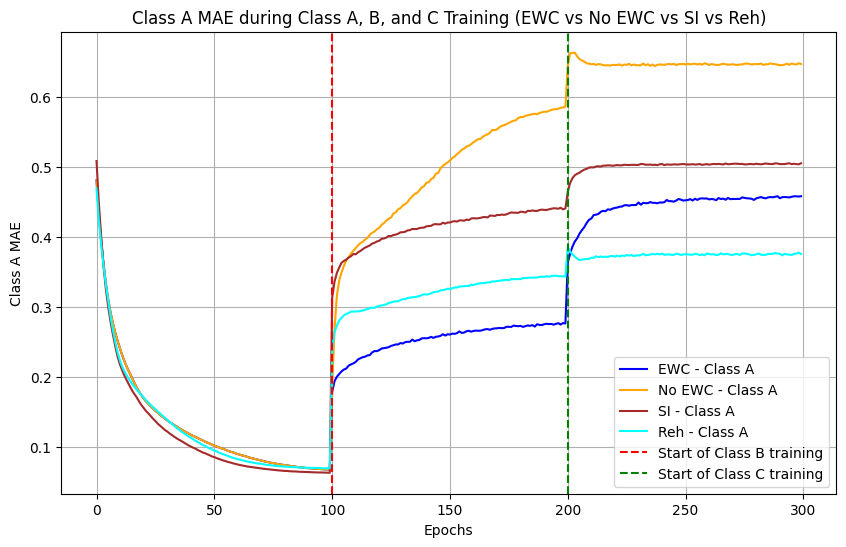

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean for Task A during Task A and Task B across all runs
ewc_initial_acc = np.mean(epoch_stats["Initial"]["A_during_A_val"], axis=0)  # Mean across runs
no_ewc_initial_acc = np.mean(epoch_stats["Initial"]["A_during_A_val"], axis=0)  # Same for No EWC
#pnn_A_during_A = np.mean(epoch_stats_other["pnn"]["A_during_A_val"], axis=0) # Same for pnn
si_A_during_A = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0) # Same for si
reh_A_during_A = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0) # Same for reh

# Now for Task A accuracy during Task B training
ewc_task_A_during_B = np.mean(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)  # Average over runs
no_ewc_task_A_during_B = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_B"], axis=0)  # Same for No EWC
#pnn_task_A_during_B = np.mean(epoch_stats_other["pnn"]["task_A_during_B"],axis=0) # Same for pnn
si_task_A_during_B = np.mean(epoch_stats_other["si"]["task_A_during_B"],axis=0) # Same for si
reh_task_A_during_B = np.mean(epoch_stats_other["reh"]["task_A_during_B"],axis=0) # Same for reh

# Now for Task A accuracy during Task C training
ewc_task_A_during_C = np.mean(epoch_stats["ewc"]["val_task_A_during_C"], axis=0)  # Average over runs
no_ewc_task_A_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_C"], axis=0)  # Same for No EWC
#pnn_task_A_during_C = np.mean(epoch_stats_other["pnn"]["task_A_during_C"],axis=0) # Same for pnn
si_task_A_during_C = np.mean(epoch_stats_other["si"]["task_A_during_C"],axis=0) # Same for si
reh_task_A_during_C = np.mean(epoch_stats_other["reh"]["task_A_during_C"],axis=0) # Same for reh

# Concatenate the Task A accuracy during Task A and Task B phases
ewc_task_A_combined = np.concatenate([ewc_initial_acc, ewc_task_A_during_B,ewc_task_A_during_C])
no_ewc_task_A_combined = np.concatenate([no_ewc_initial_acc, no_ewc_task_A_during_B,no_ewc_task_A_during_C])
#pnn_task_A_combined = np.concatenate([pnn_A_during_A, pnn_task_A_during_B,pnn_task_A_during_C])
si_task_A_combined = np.concatenate([si_A_during_A, si_task_A_during_B,si_task_A_during_C])
reh_task_A_combined = np.concatenate([reh_A_during_A, reh_task_A_during_B,reh_task_A_during_C])

# X-axis: first half for Task A training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class A', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class A', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Class A', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Class A', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Class A', color='cyan')

# Mark the point where Class B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class A MAE')
plt.title('Class A MAE during Class A, B, and C Training (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_toy_MAE_plot_taskA.png')
plt.show()


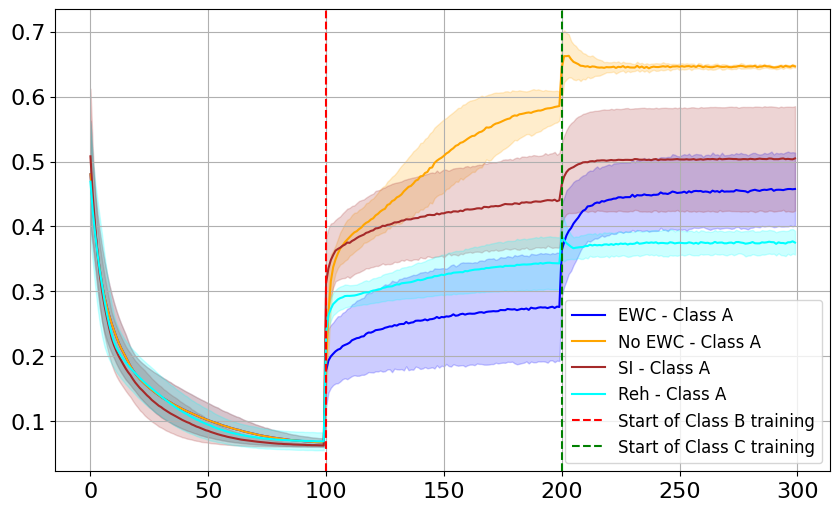

In [112]:
# Calculate mean and standard deviation for each method across runs
ewc_initial_acc_mean = np.mean(epoch_stats["Initial"]["A_during_A_val"], axis=0)
ewc_initial_acc_std = np.std(epoch_stats["Initial"]["A_during_A_val"], axis=0)
no_ewc_initial_acc_mean = np.mean(epoch_stats["Initial"]["A_during_A_val"], axis=0)
no_ewc_initial_acc_std = np.std(epoch_stats["Initial"]["A_during_A_val"], axis=0)
si_A_during_A_mean = np.mean(epoch_stats_other["si"]["A_during_A_val"], axis=0)
si_A_during_A_std = np.std(epoch_stats_other["si"]["A_during_A_val"], axis=0)
reh_A_during_A_mean = np.mean(epoch_stats_other["reh"]["A_during_A_val"], axis=0)
reh_A_during_A_std = np.std(epoch_stats_other["reh"]["A_during_A_val"], axis=0)

ewc_task_A_during_B_mean = np.mean(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)
ewc_task_A_during_B_std = np.std(epoch_stats["ewc"]["val_task_A_during_B"], axis=0)
no_ewc_task_A_during_B_mean = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_B"], axis=0)
no_ewc_task_A_during_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_B"], axis=0)
si_task_A_during_B_mean = np.mean(epoch_stats_other["si"]["task_A_during_B"], axis=0)
si_task_A_during_B_std = np.std(epoch_stats_other["si"]["task_A_during_B"], axis=0)
reh_task_A_during_B_mean = np.mean(epoch_stats_other["reh"]["task_A_during_B"], axis=0)
reh_task_A_during_B_std = np.std(epoch_stats_other["reh"]["task_A_during_B"], axis=0)

ewc_task_A_during_C_mean = np.mean(epoch_stats["ewc"]["val_task_A_during_C"], axis=0)
ewc_task_A_during_C_std = np.std(epoch_stats["ewc"]["val_task_A_during_C"], axis=0)
no_ewc_task_A_during_C_mean = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_C"], axis=0)
no_ewc_task_A_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_A_during_C"], axis=0)
si_task_A_during_C_mean = np.mean(epoch_stats_other["si"]["task_A_during_C"], axis=0)
si_task_A_during_C_std = np.std(epoch_stats_other["si"]["task_A_during_C"], axis=0)
reh_task_A_during_C_mean = np.mean(epoch_stats_other["reh"]["task_A_during_C"], axis=0)
reh_task_A_during_C_std = np.std(epoch_stats_other["reh"]["task_A_during_C"], axis=0)

# Concatenate mean and std for combined phases
ewc_task_A_combined_mean = np.concatenate([ewc_initial_acc_mean, ewc_task_A_during_B_mean, ewc_task_A_during_C_mean])
ewc_task_A_combined_std = np.concatenate([ewc_initial_acc_std, ewc_task_A_during_B_std, ewc_task_A_during_C_std])
no_ewc_task_A_combined_mean = np.concatenate([no_ewc_initial_acc_mean, no_ewc_task_A_during_B_mean, no_ewc_task_A_during_C_mean])
no_ewc_task_A_combined_std = np.concatenate([no_ewc_initial_acc_std, no_ewc_task_A_during_B_std, no_ewc_task_A_during_C_std])
si_task_A_combined_mean = np.concatenate([si_A_during_A_mean, si_task_A_during_B_mean, si_task_A_during_C_mean])
si_task_A_combined_std = np.concatenate([si_A_during_A_std, si_task_A_during_B_std, si_task_A_during_C_std])
reh_task_A_combined_mean = np.concatenate([reh_A_during_A_mean, reh_task_A_during_B_mean, reh_task_A_during_C_mean])
reh_task_A_combined_std = np.concatenate([reh_A_during_A_std, reh_task_A_during_B_std, reh_task_A_during_C_std])

# Plotting with variance bands
plt.figure(figsize=(10, 6))
x_values = np.arange(len(ewc_task_A_combined_mean))

# EWC
plt.plot(x_values, ewc_task_A_combined_mean, label='EWC - Class A', color='blue')
plt.fill_between(x_values, ewc_task_A_combined_mean - ewc_task_A_combined_std,
                 ewc_task_A_combined_mean + ewc_task_A_combined_std, color='blue', alpha=0.2)

# No EWC
plt.plot(x_values, no_ewc_task_A_combined_mean, label='No EWC - Class A', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined_mean - no_ewc_task_A_combined_std,
                 no_ewc_task_A_combined_mean + no_ewc_task_A_combined_std, color='orange', alpha=0.2)

# SI
plt.plot(x_values, si_task_A_combined_mean, label='SI - Class A', color='brown')
plt.fill_between(x_values, si_task_A_combined_mean - si_task_A_combined_std,
                 si_task_A_combined_mean + si_task_A_combined_std, color='brown', alpha=0.2)

# Reh
plt.plot(x_values, reh_task_A_combined_mean, label='Reh - Class A', color='cyan')
plt.fill_between(x_values, reh_task_A_combined_mean - reh_task_A_combined_std,
                 reh_task_A_combined_mean + reh_task_A_combined_std, color='cyan', alpha=0.2)

# Mark points where Class B and Class C training begin
plt.axvline(x=len(ewc_initial_acc_mean), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc_mean) + len(ewc_task_A_during_B_mean), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=12)
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_toy_MAE_plot_taskA_variance_bigger.png')
plt.show()


In [60]:
epoch_stats_no_ewc["ewc"]["val_task_B"]

[[0.45547530181864476,
  0.4347414089010117,
  0.4219871613573521,
  0.4135945388611327,
  0.4072903901972669,
  0.4004844433449684,
  0.3941382696019842,
  0.38986181451919233,
  0.386889489407235,
  0.38300812054187694,
  0.37913003310244137,
  0.37524664845872435,
  0.3725412044119328,
  0.3696510652278332,
  0.36719609828705485,
  0.3646827625467422,
  0.36114968264356573,
  0.35873972672097226,
  0.35653308414398355,
  0.35311908671196474,
  0.3516156965113701,
  0.3480722358886232,
  0.346575972881723,
  0.34391292295557385,
  0.3422749194693058,
  0.3400000511331761,
  0.33820280939974684,
  0.33645421076328197,
  0.33492788482219615,
  0.3330877556445751,
  0.3305235289512797,
  0.3289967737299331,
  0.32768965211320433,
  0.3254555495495492,
  0.32548788063069606,
  0.32306500825476137,
  0.3210363013947264,
  0.3200620970827468,
  0.3191051166108314,
  0.31775389738539433,
  0.3167737069282126,
  0.31574046548376694,
  0.31500822369088516,
  0.3130193825097794,
  0.3117894114

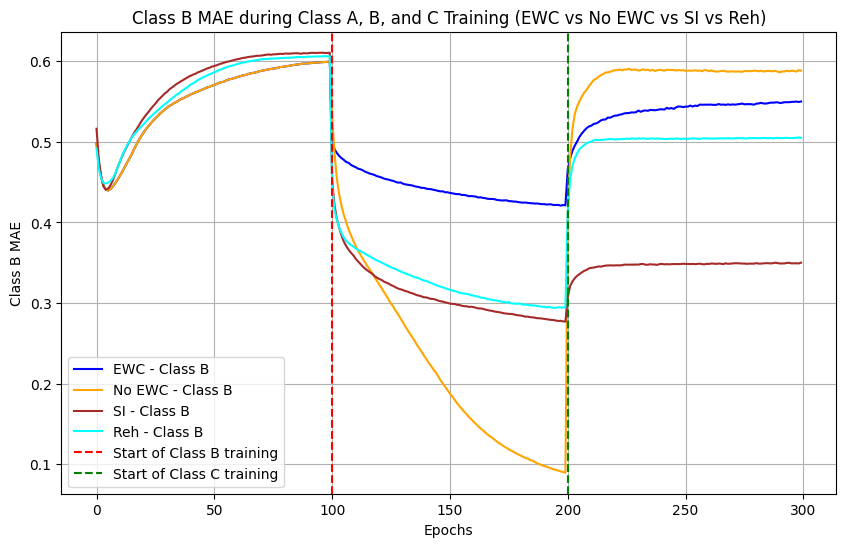

In [113]:
import matplotlib.pyplot as plt
# Calculate the mean for Task A during Class B and Task B across all runs
ewc_B_during_A = np.mean(epoch_stats["Initial"]["B_during_A_val"], axis=0)  # Mean across runs
no_ewc_B_during_A = np.mean(epoch_stats["Initial"]["B_during_A_val"], axis=0)  # Same for No EWC
#pnn_B_during_A = np.mean(epoch_stats_other["pnn"]["B_during_A_val"], axis=0) # Same for pnn
si_B_during_A = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0) # Same for si
reh_B_during_A = np.mean(epoch_stats_other["reh"]["B_during_A_val"], axis=0) # Same for reh

# Now Task B training
ewc_task_B = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)  # Average over runs
no_ewc_task_B = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)  # Same for No EWC
#pnn_task_B = np.mean(epoch_stats_other["pnn"]["val_task_B"],axis=0) # Same for pnn
si_task_B = np.mean(epoch_stats_other["si"]["val_task_B"],axis=0) # Same for si
reh_task_B = np.mean(epoch_stats_other["reh"]["val_task_B"],axis=0) # Same for reh

# Now for Class B accuracy during Task C training
ewc_task_B_during_C = np.mean(epoch_stats["ewc"]["val_task_B_during_C"], axis=0)  # Average over runs
no_ewc_task_B_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B_during_C"], axis=0)  # Same for No EWC
#pnn_task_B_during_C = np.mean(epoch_stats_other["pnn"]["task_B_during_C"],axis=0) # Same for pnn
si_task_B_during_C = np.mean(epoch_stats_other["si"]["task_B_during_C"],axis=0) # Same for si
reh_task_B_during_C = np.mean(epoch_stats_other["reh"]["task_B_during_C"],axis=0) # Same for reh


# Concatenate the Class B accuracy during Class B and Task B phases
ewc_task_A_combined = np.concatenate([ewc_B_during_A, ewc_task_B, ewc_task_B_during_C])
no_ewc_task_A_combined = np.concatenate([no_ewc_B_during_A,no_ewc_task_B, no_ewc_task_B_during_C])
#pnn_task_A_combined = np.concatenate([pnn_B_during_A,pnn_task_B, pnn_task_B_during_C])
si_task_A_combined = np.concatenate([si_B_during_A,si_task_B, si_task_B_during_C])
reh_task_A_combined = np.concatenate([reh_B_during_A,reh_task_B, reh_task_B_during_C])

# X-axis: first half for Class B training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class B', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class B', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Class B', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Class B', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Class B', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class B MAE')
plt.title('Class B MAE during Class A, B, and C Training (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_toy_MAE_plot_taskB.png')
plt.show()


In [210]:
epoch_stats["ewc"]["val_task_C_during_B"]

[[0.6733333333333333, 0.6663333333333333, 0.656, 0.6553333333333333, 0.656]]

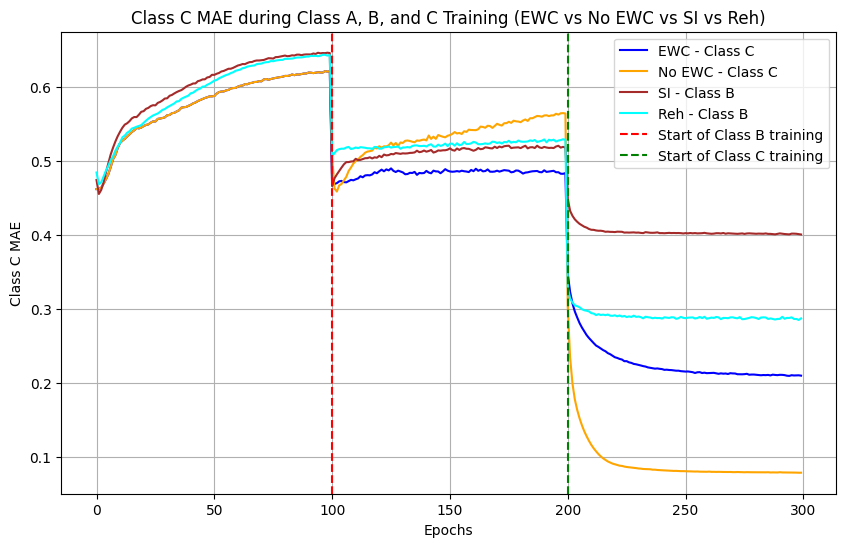

In [108]:
import matplotlib.pyplot as plt
# Calculate the mean for Task A during Class B and Task B across all runs
ewc_B_during_A = np.mean(epoch_stats["Initial"]["C_during_A_val"], axis=0)  # Mean across runs
no_ewc_B_during_A = np.mean(epoch_stats["Initial"]["C_during_A_val"], axis=0)  # Same for No EWC
#pnn_B_during_A = np.mean(epoch_stats_other["pnn"]["B_during_A_val"], axis=0) # Same for pnn
si_B_during_A = np.mean(epoch_stats_other["si"]["C_during_A_val"], axis=0) # Same for si
reh_B_during_A = np.mean(epoch_stats_other["reh"]["C_during_A_val"], axis=0) # Same for reh

# Now Task B training
ewc_task_B = np.mean(epoch_stats["ewc"]["val_task_C_during_B"], axis=0)  # Average over runs
no_ewc_task_B = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C_during_B"], axis=0)  # Same for No EWC
#pnn_task_B = np.mean(epoch_stats_other["pnn"]["val_task_B"],axis=0) # Same for pnn
si_task_B = np.mean(epoch_stats_other["si"]["C_during_B_val"],axis=0) # Same for si
reh_task_B = np.mean(epoch_stats_other["reh"]["C_during_B_val"],axis=0) # Same for reh

# Now for Class B accuracy during Task C training
ewc_task_B_during_C = np.mean(epoch_stats["ewc"]["val_task_C"], axis=0)  # Average over runs
no_ewc_task_B_during_C = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)  # Same for No EWC
#pnn_task_B_during_C = np.mean(epoch_stats_other["pnn"]["task_B_during_C"],axis=0) # Same for pnn
si_task_B_during_C = np.mean(epoch_stats_other["si"]["val_task_C"],axis=0) # Same for si
reh_task_B_during_C = np.mean(epoch_stats_other["reh"]["val_task_C"],axis=0) # Same for reh


# Concatenate the Class B accuracy during Class B and Task B phases
ewc_task_A_combined = np.concatenate([ewc_B_during_A, ewc_task_B, ewc_task_B_during_C])
no_ewc_task_A_combined = np.concatenate([no_ewc_B_during_A,no_ewc_task_B, no_ewc_task_B_during_C])
#pnn_task_A_combined = np.concatenate([pnn_B_during_A,pnn_task_B, pnn_task_B_during_C])
si_task_A_combined = np.concatenate([si_B_during_A,si_task_B, si_task_B_during_C])
reh_task_A_combined = np.concatenate([reh_B_during_A,reh_task_B, reh_task_B_during_C])

# X-axis: first half for Class B training, second half for Task B training
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class C', color='blue')
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class C', color='orange')
#plt.plot(x_values, pnn_task_A_combined, label='PNN - Class B', color='green')
plt.plot(x_values, si_task_A_combined, label='SI - Class B', color='brown')
plt.plot(x_values, reh_task_A_combined, label='Reh - Class B', color='cyan')

# Mark the point where Task B training begins
plt.axvline(x=len(ewc_initial_acc), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_initial_acc) + len(ewc_task_A_during_B), color='green', linestyle='--', label='Start of Class C training')


# Labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Class C MAE')
plt.title('Class C MAE during Class A, B, and C Training (EWC vs No EWC vs SI vs Reh)')
plt.legend()
plt.grid(True)

# Save and show the plot
#plt.savefig('cil_toy_MAE_plot_taskC.png')
plt.show()


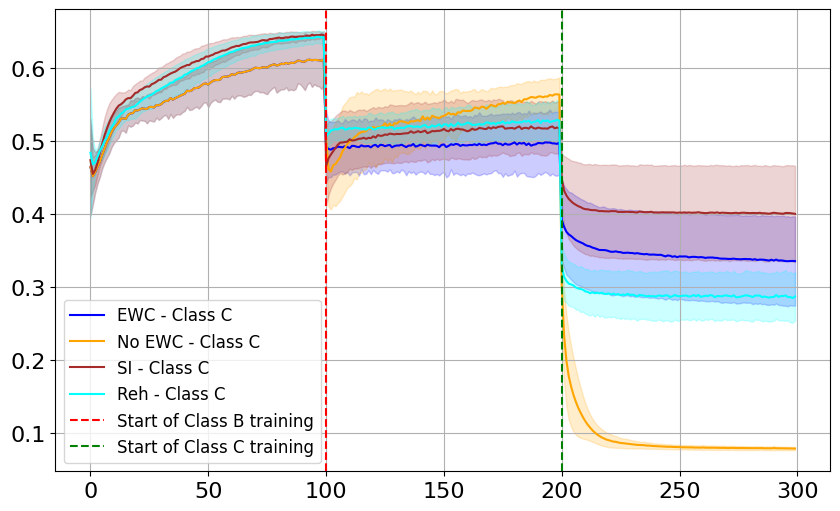

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for each method
ewc_B_during_A_mean = np.mean(epoch_stats["Initial"]["C_during_A_val"], axis=0)
ewc_B_during_A_std = np.std(epoch_stats["Initial"]["C_during_A_val"], axis=0)
no_ewc_B_during_A_mean = np.mean(epoch_stats["Initial"]["C_during_A_val"], axis=0)
no_ewc_B_during_A_std = np.std(epoch_stats["Initial"]["C_during_A_val"], axis=0)
si_B_during_A_mean = np.mean(epoch_stats_other["si"]["C_during_A_val"], axis=0)
si_B_during_A_std = np.std(epoch_stats_other["si"]["C_during_A_val"], axis=0)
reh_B_during_A_mean = np.mean(epoch_stats_other["reh"]["C_during_A_val"], axis=0)
reh_B_during_A_std = np.std(epoch_stats_other["reh"]["C_during_A_val"], axis=0)

ewc_task_B_mean = np.mean(epoch_stats_no_ewc["ewc"]["val_task_C_during_B"], axis=0)
ewc_task_B_std = np.std(epoch_stats_no_ewc["ewc"]["val_task_C_during_B"], axis=0)
no_ewc_task_B_mean = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C_during_B"], axis=0)
no_ewc_task_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_C_during_B"], axis=0)
si_task_B_mean = np.mean(epoch_stats_other["si"]["C_during_B_val"], axis=0)
si_task_B_std = np.std(epoch_stats_other["si"]["C_during_B_val"], axis=0)
reh_task_B_mean = np.mean(epoch_stats_other["reh"]["C_during_B_val"], axis=0)
reh_task_B_std = np.std(epoch_stats_other["reh"]["C_during_B_val"], axis=0)

ewc_task_B_during_C_mean = np.mean(epoch_stats_no_ewc["ewc"]["val_task_C"], axis=0)
ewc_task_B_during_C_std = np.std(epoch_stats_no_ewc["ewc"]["val_task_C"], axis=0)
no_ewc_task_B_during_C_mean = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)
no_ewc_task_B_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_C"], axis=0)
si_task_B_during_C_mean = np.mean(epoch_stats_other["si"]["val_task_C"], axis=0)
si_task_B_during_C_std = np.std(epoch_stats_other["si"]["val_task_C"], axis=0)
reh_task_B_during_C_mean = np.mean(epoch_stats_other["reh"]["val_task_C"], axis=0)
reh_task_B_during_C_std = np.std(epoch_stats_other["reh"]["val_task_C"], axis=0)

# Combine the metrics
ewc_task_A_combined = np.concatenate([ewc_B_during_A_mean, ewc_task_B_mean, ewc_task_B_during_C_mean])
ewc_task_A_std_combined = np.concatenate([ewc_B_during_A_std, ewc_task_B_std, ewc_task_B_during_C_std])
no_ewc_task_A_combined = np.concatenate([no_ewc_B_during_A_mean, no_ewc_task_B_mean, no_ewc_task_B_during_C_mean])
no_ewc_task_A_std_combined = np.concatenate([no_ewc_B_during_A_std, no_ewc_task_B_std, no_ewc_task_B_during_C_std])
si_task_A_combined = np.concatenate([si_B_during_A_mean, si_task_B_mean, si_task_B_during_C_mean])
si_task_A_std_combined = np.concatenate([si_B_during_A_std, si_task_B_std, si_task_B_during_C_std])
reh_task_A_combined = np.concatenate([reh_B_during_A_mean, reh_task_B_mean, reh_task_B_during_C_mean])
reh_task_A_std_combined = np.concatenate([reh_B_during_A_std, reh_task_B_std, reh_task_B_during_C_std])

# X-axis
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class C', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_std_combined, ewc_task_A_combined + ewc_task_A_std_combined, color='blue', alpha=0.2)
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class C', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_std_combined, no_ewc_task_A_combined + no_ewc_task_A_std_combined, color='orange', alpha=0.2)
plt.plot(x_values, si_task_A_combined, label='SI - Class C', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_std_combined, si_task_A_combined + si_task_A_std_combined, color='brown', alpha=0.2)
plt.plot(x_values, reh_task_A_combined, label='Reh - Class C', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_std_combined, reh_task_A_combined + reh_task_A_std_combined, color='cyan', alpha=0.2)

# Vertical lines for phase changes
plt.axvline(x=len(ewc_B_during_A_mean), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_B_during_A_mean) + len(ewc_task_B_mean), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=12)
plt.grid(True)

# Save and show the plot
plt.savefig('cil_toy_accuracy_plot_taskC_with_variance_bigger.png')
plt.show()


In [542]:
epoch_stats["no_ewc"]["val_task_B_during_C"]

[]

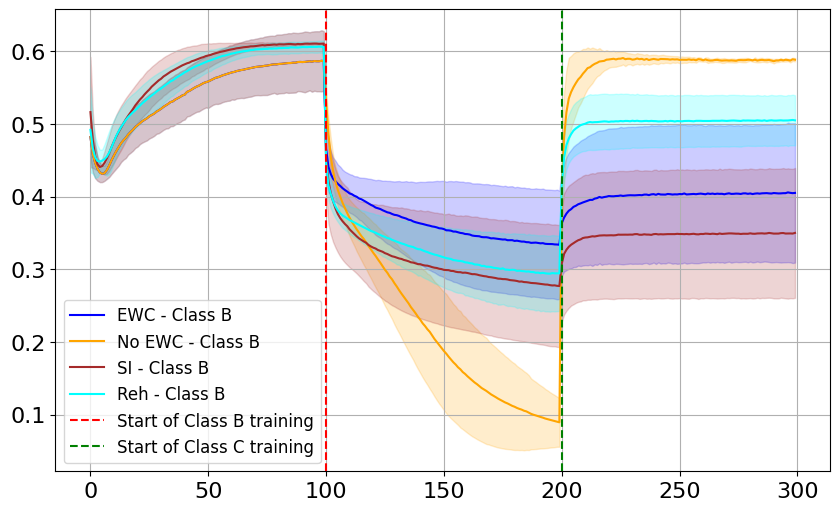

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean and standard deviation for each method
ewc_B_during_A_mean = np.mean(epoch_stats["Initial"]["B_during_A_val"], axis=0)
ewc_B_during_A_std = np.std(epoch_stats["Initial"]["B_during_A_val"], axis=0)
no_ewc_B_during_A_mean = np.mean(epoch_stats["Initial"]["B_during_A_val"], axis=0)
no_ewc_B_during_A_std = np.std(epoch_stats["Initial"]["B_during_A_val"], axis=0)
si_B_during_A_mean = np.mean(epoch_stats_other["si"]["B_during_A_val"], axis=0)
si_B_during_A_std = np.std(epoch_stats_other["si"]["B_during_A_val"], axis=0)
reh_B_during_A_mean = np.mean(epoch_stats_other["reh"]["B_during_A_val"], axis=0)
reh_B_during_A_std = np.std(epoch_stats_other["reh"]["B_during_A_val"], axis=0)

ewc_task_B_mean = np.mean(epoch_stats["ewc"]["val_task_B"], axis=0)
ewc_task_B_std = np.std(epoch_stats["ewc"]["val_task_B"], axis=0)
no_ewc_task_B_mean = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)
no_ewc_task_B_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_B"], axis=0)
si_task_B_mean = np.mean(epoch_stats_other["si"]["val_task_B"], axis=0)
si_task_B_std = np.std(epoch_stats_other["si"]["val_task_B"], axis=0)
reh_task_B_mean = np.mean(epoch_stats_other["reh"]["val_task_B"], axis=0)
reh_task_B_std = np.std(epoch_stats_other["reh"]["val_task_B"], axis=0)

ewc_task_B_during_C_mean = np.mean(epoch_stats["ewc"]["val_task_B_during_C"], axis=0)
ewc_task_B_during_C_std = np.std(epoch_stats["ewc"]["val_task_B_during_C"], axis=0)
no_ewc_task_B_during_C_mean = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_B_during_C"], axis=0)
no_ewc_task_B_during_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_B_during_C"], axis=0)
si_task_B_during_C_mean = np.mean(epoch_stats_other["si"]["task_B_during_C"], axis=0)
si_task_B_during_C_std = np.std(epoch_stats_other["si"]["task_B_during_C"], axis=0)
reh_task_B_during_C_mean = np.mean(epoch_stats_other["reh"]["task_B_during_C"], axis=0)
reh_task_B_during_C_std = np.std(epoch_stats_other["reh"]["task_B_during_C"], axis=0)

# Combine the metrics
ewc_task_A_combined = np.concatenate([ewc_B_during_A_mean, ewc_task_B_mean, ewc_task_B_during_C_mean])
ewc_task_A_std_combined = np.concatenate([ewc_B_during_A_std, ewc_task_B_std, ewc_task_B_during_C_std])
no_ewc_task_A_combined = np.concatenate([no_ewc_B_during_A_mean, no_ewc_task_B_mean, no_ewc_task_B_during_C_mean])
no_ewc_task_A_std_combined = np.concatenate([no_ewc_B_during_A_std, no_ewc_task_B_std, no_ewc_task_B_during_C_std])
si_task_A_combined = np.concatenate([si_B_during_A_mean, si_task_B_mean, si_task_B_during_C_mean])
si_task_A_std_combined = np.concatenate([si_B_during_A_std, si_task_B_std, si_task_B_during_C_std])
reh_task_A_combined = np.concatenate([reh_B_during_A_mean, reh_task_B_mean, reh_task_B_during_C_mean])
reh_task_A_std_combined = np.concatenate([reh_B_during_A_std, reh_task_B_std, reh_task_B_during_C_std])

# X-axis
total_epochs = len(ewc_task_A_combined)
x_values = np.arange(total_epochs)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_values, ewc_task_A_combined, label='EWC - Class B', color='blue')
plt.fill_between(x_values, ewc_task_A_combined - ewc_task_A_std_combined, ewc_task_A_combined + ewc_task_A_std_combined, color='blue', alpha=0.2)
plt.plot(x_values, no_ewc_task_A_combined, label='No EWC - Class B', color='orange')
plt.fill_between(x_values, no_ewc_task_A_combined - no_ewc_task_A_std_combined, no_ewc_task_A_combined + no_ewc_task_A_std_combined, color='orange', alpha=0.2)
plt.plot(x_values, si_task_A_combined, label='SI - Class B', color='brown')
plt.fill_between(x_values, si_task_A_combined - si_task_A_std_combined, si_task_A_combined + si_task_A_std_combined, color='brown', alpha=0.2)
plt.plot(x_values, reh_task_A_combined, label='Reh - Class B', color='cyan')
plt.fill_between(x_values, reh_task_A_combined - reh_task_A_std_combined, reh_task_A_combined + reh_task_A_std_combined, color='cyan', alpha=0.2)

# Vertical lines for phase changes
plt.axvline(x=len(ewc_B_during_A_mean), color='red', linestyle='--', label='Start of Class B training')
plt.axvline(x=len(ewc_B_during_A_mean) + len(ewc_task_B_mean), color='green', linestyle='--', label='Start of Class C training')

# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=12)
plt.grid(True)

# Save and show the plot
plt.savefig('cil_toy_MAE_plot_taskB_with_variance_bigger.png')
plt.show()


In [84]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# epoch_stats
# epoch_stats_other
# filtered_reh
# epoch_stats_no_ewc

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A_ewc = np.mean(np.array(epoch_stats["Initial"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A = np.mean(np.array(epoch_stats["Initial"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_si = np.mean(np.array(epoch_stats_other["si"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_reh = np.mean(np.array(epoch_stats_other["reh"]["A_during_A_val"])[:, -1])

# Helper function to calculate max, min, mean, std, and bounds for final epoch
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_values = data[:, -1]  # Extract values from the last epoch

    max_final = np.max(final_epoch_values)  # Max of the final epoch
    min_final = np.min(final_epoch_values)  # Min of the final epoch
    mean_final = np.mean(final_epoch_values)  # Mean of the final epoch
    std_final = np.std(final_epoch_values)  # Standard deviation of the final epoch

    upper_bound = mean_final + 2 * std_final  # Mean + 2*STD
    lower_bound = mean_final - 2 * std_final  # Mean - 2*STD

    return max_final, min_final, mean_final, std_final, upper_bound, lower_bound

# Extract final epoch statistics for Task A during Task B training (with bounds)
ewc_max_final, ewc_min_final, ewc_mean_final, ewc_std_final, ewc_upper, ewc_lower = calculate_final_epoch_stats_from_dict(epoch_stats["ewc"], "val_task_A_during_B")
no_ewc_max_final, no_ewc_min_final, no_ewc_mean_final, no_ewc_std_final, no_ewc_upper, no_ewc_lower = calculate_final_epoch_stats_from_dict(epoch_stats_no_ewc["no_ewc"], "val_task_A_during_B")
si_max_final, si_min_final, si_mean_final, si_std_final, si_upper, si_lower = calculate_final_epoch_stats_from_dict(epoch_stats_other["si"], "val_task_A_during_B")
reh_max_final, reh_min_final, reh_mean_final, reh_std_final, reh_upper, reh_lower = calculate_final_epoch_stats_from_dict(epoch_stats_other["reh"], "val_task_A_during_B")

# Extract final epoch statistics for Task A during Task C training (with bounds)
ewc_max_final_C, ewc_min_final_C, ewc_mean_final_C, ewc_std_final_C, ewc_upper_C, ewc_lower_C = calculate_final_epoch_stats_from_dict(epoch_stats["ewc"], "val_task_A_during_C")
no_ewc_max_final_C, no_ewc_min_final_C, no_ewc_mean_final_C, no_ewc_std_final_C, no_ewc_upper_C, no_ewc_lower_C = calculate_final_epoch_stats_from_dict(epoch_stats_no_ewc["no_ewc"], "val_task_A_during_C")
si_max_final_C, si_min_final_C, si_mean_final_C, si_std_final_C, si_upper_C, si_lower_C = calculate_final_epoch_stats_from_dict(epoch_stats_other["si"], "val_task_A_during_C")
reh_max_final_C, reh_min_final_C, reh_mean_final_C, reh_std_final_C, reh_upper_C, reh_lower_C = calculate_final_epoch_stats_from_dict(epoch_stats_other["reh"], "val_task_A_during_C")

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_A_A_ewc = np.mean(np.array(epoch_stats["Initial"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_si = np.mean(np.array(epoch_stats_other["si"]["A_during_A_val"])[:, -1])
avg_final_epoch_task_A_A_reh = np.mean(np.array(epoch_stats_other["reh"]["A_during_A_val"])[:, -1])

# Create a summary table for Task A during Task B training (including bounds)
final_epoch_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Class A After A": [avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Mean Acc After B": [ewc_mean_final, no_ewc_mean_final, si_mean_final, reh_mean_final],
    "Max Acc After B": [ewc_max_final, no_ewc_max_final, si_max_final, reh_max_final],
    "Min Acc After B": [ewc_min_final, no_ewc_min_final, si_min_final, reh_min_final],
    "Upper Bound After B": [ewc_upper, no_ewc_upper, si_upper, reh_upper],
    "Lower Bound After B": [ewc_lower, no_ewc_lower, si_lower, reh_lower]
})

# Create a summary table for Task A during Task C training (including bounds)
final_epoch_summary_after_C = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Class A After A": [avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_ewc, avg_final_epoch_task_A_A_si, avg_final_epoch_task_A_A_reh],
    "Mean Acc After B": [ewc_mean_final, no_ewc_mean_final, si_mean_final, reh_mean_final],
    "Mean Acc After C": [ewc_mean_final_C, no_ewc_mean_final_C, si_mean_final_C, reh_mean_final_C],
    "Max Acc After C": [ewc_max_final_C, no_ewc_max_final_C, si_max_final_C, reh_max_final_C],
    "Min Acc After C": [ewc_min_final_C, no_ewc_min_final_C, si_min_final_C, reh_min_final_C],
    "Upper Bound After C": [ewc_upper_C, no_ewc_upper_C, si_upper_C, reh_upper_C],
    "Lower Bound After C": [ewc_lower_C, no_ewc_lower_C, si_lower_C, reh_lower_C]
})


print("Class A Performance After Training on Class A and After Class B")
print(final_epoch_summary)

print("\nClass A Performance After Training on Class A, B and C")
print(final_epoch_summary_after_C)





Class A Performance After Training on Class A and After Class B
      Method  Class A After A  Mean Acc After B  Max Acc After B  \
0        EWC         0.083031          0.387149         0.530472   
1     No EWC         0.083031          0.585417         0.601684   
2         SI         0.062626          0.432672         0.557936   
3  Rehearsal         0.068908          0.334147         0.380080   

   Min Acc After B  Upper Bound After B  Lower Bound After B  
0         0.286392             0.527841             0.246456  
1         0.529009             0.629852             0.540982  
2         0.332540             0.571708             0.293636  
3         0.259138             0.411572             0.256722  

Class A Performance After Training on Class A, B and C
      Method  Class A After A  Mean Acc After B  Mean Acc After C  \
0        EWC         0.083031          0.387149          0.451089   
1     No EWC         0.083031          0.585417          0.646542   
2         SI     

In [86]:
# Extract data directly from dictionaries without modifying their original structure
import pandas as pd
# Helper function to calculate max, min, and mean for final epoch from a dictionary
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    return max_final, min_final, mean_final

# epoch_stats
# epoch_stats_other
# filtered_reh
# epoch_stats_no_ewc

# Average of the final epoch for Task A during Task A training
avg_final_epoch_task_B_ewc = np.mean(np.array(epoch_stats["ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B = np.mean(np.array(epoch_stats_no_ewc["no_ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_si = np.mean(np.array(epoch_stats_other["si"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_reh = np.mean(np.array(epoch_stats_other["reh"]["val_task_B"])[:, -1])

# Helper function to calculate max, min, mean, std, and bounds for final epoch
def calculate_final_epoch_stats_from_dict(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_values = data[:, -1]  # Extract values from the last epoch

    max_final = np.max(final_epoch_values)  # Max of the final epoch
    min_final = np.min(final_epoch_values)  # Min of the final epoch
    mean_final = np.mean(final_epoch_values)  # Mean of the final epoch
    std_final = np.std(final_epoch_values)  # Standard deviation of the final epoch

    upper_bound = mean_final + 2 * std_final  # Mean + 2*STD
    lower_bound = mean_final - 2 * std_final  # Mean - 2*STD

    return max_final, min_final, mean_final, std_final, upper_bound, lower_bound

# Average of the final epoch for Task B during Task B training
avg_final_epoch_task_B_ewc = np.mean(np.array(epoch_stats["ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B = np.mean(np.array(epoch_stats_no_ewc["no_ewc"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_si = np.mean(np.array(epoch_stats_other["si"]["val_task_B"])[:, -1])
avg_final_epoch_task_B_reh = np.mean(np.array(epoch_stats_other["reh"]["val_task_B"])[:, -1])

# Extract final epoch statistics for Task B during Task C training (with bounds)
ewc_max_final_B_after_C, ewc_min_final_B_after_C, ewc_mean_final_B_after_C, ewc_std_final_B_after_C, ewc_upper_B_after_C, ewc_lower_B_after_C = calculate_final_epoch_stats_from_dict(epoch_stats["ewc"], "val_task_B_during_C")
no_ewc_max_final_B_after_C, no_ewc_min_final_B_after_C, no_ewc_mean_final_B_after_C, no_ewc_std_final_B_after_C, no_ewc_upper_B_after_C, no_ewc_lower_B_after_C = calculate_final_epoch_stats_from_dict(epoch_stats_no_ewc["no_ewc"], "val_task_B_during_C")
si_max_final_B_after_C, si_min_final_B_after_C, si_mean_final_B_after_C, si_std_final_B_after_C, si_upper_B_after_C, si_lower_B_after_C = calculate_final_epoch_stats_from_dict(epoch_stats_other["si"], "val_task_B_during_C")
reh_max_final_B_after_C, reh_min_final_B_after_C, reh_mean_final_B_after_C, reh_std_final_B_after_C, reh_upper_B_after_C, reh_lower_B_after_C = calculate_final_epoch_stats_from_dict(epoch_stats_other["reh"], "val_task_B_during_C")

# Create a summary table for Task B during Task C training (including bounds)
final_epoch_summary_B_after_C = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Class B After B": [avg_final_epoch_task_B_ewc, avg_final_epoch_task_B, avg_final_epoch_task_B_si, avg_final_epoch_task_B_reh],
    "Mean MAE After C": [ewc_mean_final_B_after_C, no_ewc_mean_final_B_after_C, si_mean_final_B_after_C, reh_mean_final_B_after_C],
    "Max MAE After C": [ewc_max_final_B_after_C, no_ewc_max_final_B_after_C , si_max_final_B_after_C, reh_max_final_B_after_C],
    "Min MAE After C": [ewc_min_final_B_after_C, no_ewc_min_final_B_after_C, si_min_final_B_after_C, reh_min_final_B_after_C],
    "Upper Bound After C": [ewc_upper_B_after_C, no_ewc_upper_B_after_C, si_upper_B_after_C, reh_upper_B_after_C],
    "Lower Bound After C": [ewc_lower_B_after_C, no_ewc_lower_B_after_C, si_lower_B_after_C, reh_lower_B_after_C]
})

# Display results
# Display results using print for both tables


print("Class B Performance After Training on Class B and After Class C")
print(final_epoch_summary_B_after_C)




Class B Performance After Training on Class B and After Class C
      Method  Class B After B  Mean MAE After C  Max MAE After C  \
0        EWC         0.333813          0.405140         0.563338   
1     No EWC         0.089496          0.588444         0.592661   
2         SI         0.276979          0.352130         0.501091   
3  Rehearsal         0.294494          0.518543         0.563510   

   Min MAE After C  Upper Bound After C  Lower Bound After C  
0         0.207330             0.596782             0.213499  
1         0.585523             0.593071             0.583816  
2         0.220968             0.531325             0.172935  
3         0.429597             0.589970             0.447116  


In [88]:
### Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate mean, max, min, std, and bounds for the final epoch
def calculate_final_epoch_stats_class_C(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    final_epoch_values = data[:, -1]  # Extract values from the last epoch

    mean_final = np.mean(final_epoch_values)  # Mean of the final epoch
    max_final = np.max(final_epoch_values)  # Max of the final epoch
    min_final = np.min(final_epoch_values)  # Min of the final epoch
    std_final = np.std(final_epoch_values)  # Standard deviation of the final epoch

    upper_bound = mean_final + 2 * std_final  # Mean + 2*STD
    lower_bound = mean_final - 2 * std_final  # Mean - 2*STD

    return mean_final, max_final, min_final, std_final, upper_bound, lower_bound

# Calculate stats for each method (including bounds)
class_C_ewc_mean, class_C_ewc_max, class_C_ewc_min, class_C_ewc_std, class_C_ewc_upper, class_C_ewc_lower = calculate_final_epoch_stats_class_C(epoch_stats["ewc"], "val_task_C")
class_C_no_ewc_mean, class_C_no_ewc_max, class_C_no_ewc_min, class_C_no_ewc_std, class_C_no_ewc_upper, class_C_no_ewc_lower = calculate_final_epoch_stats_class_C(epoch_stats_no_ewc["no_ewc"], "val_task_C")
class_C_si_mean, class_C_si_max, class_C_si_min, class_C_si_std, class_C_si_upper, class_C_si_lower = calculate_final_epoch_stats_class_C(epoch_stats_other["si"], "val_task_C")
class_C_reh_mean, class_C_reh_max, class_C_reh_min, class_C_reh_std, class_C_reh_upper, class_C_reh_lower = calculate_final_epoch_stats_class_C(epoch_stats_other["reh"], "val_task_C")

# Create a summary table for Task C training (including bounds)
final_epoch_task_C_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Mean Final MAE": [class_C_ewc_mean, class_C_no_ewc_mean, class_C_si_mean, class_C_reh_mean],
    "Max Final MAE": [class_C_ewc_max, class_C_no_ewc_max, class_C_si_max, class_C_reh_max],
    "Min Final MAE": [class_C_ewc_min, class_C_no_ewc_min, class_C_si_min, class_C_reh_min],
    "Upper Bound (Mean + 2*STD)": [class_C_ewc_upper, class_C_no_ewc_upper, class_C_si_upper, class_C_reh_upper],
    "Lower Bound (Mean - 2*STD)": [class_C_ewc_lower, class_C_no_ewc_lower, class_C_si_lower, class_C_reh_lower]
})
# Display results for Task B
print("Final MAE for Class C")
print(final_epoch_task_C_summary)


Final MAE for Class C
      Method  Mean Final MAE  Max Final MAE  Min Final MAE  \
0        EWC        0.385942       0.473560       0.232992   
1     No EWC        0.079099       0.085287       0.077400   
2         SI        0.400518       0.464063       0.245690   
3  Rehearsal        0.287326       0.382376       0.259175   

   Upper Bound (Mean + 2*STD)  Lower Bound (Mean - 2*STD)  
0                    0.529409                    0.242474  
1                    0.083664                    0.074535  
2                    0.531961                    0.269075  
3                    0.354107                    0.220545  


In [576]:
# Calculate statistics for the final epoch of Task B during Task B training

# Helper function to calculate mean, max, and min for the final epoch
def calculate_final_epoch_stats_class_B(data_dict, key):
    data = np.array(data_dict[key])  # Convert to NumPy array
    mean_final = np.mean(data[:, -1])  # Mean of the final epoch
    max_final = np.max(data[:, -1])  # Max of the final epoch
    min_final = np.min(data[:, -1])  # Min of the final epoch
    return mean_final, max_final, min_final

# Calculate stats for each method
class_B_ewc_mean, class_B_ewc_max, class_B_ewc_min = calculate_final_epoch_stats_class_B(epoch_stats["ewc"], "val_task_B")
class_B_no_ewc_mean, class_B_no_ewc_max, class_B_no_ewc_min = calculate_final_epoch_stats_class_B(epoch_stats_no_ewc["no_ewc"], "val_task_B")
class_B_si_mean, class_B_si_max, class_B_si_min = calculate_final_epoch_stats_class_B(epoch_stats_other["si"], "val_task_B")
class_B_reh_mean, class_B_reh_max, class_B_reh_min = calculate_final_epoch_stats_class_B(epoch_stats_other["reh"], "val_task_B")

# Create a summary table for Task B during Task B training
final_epoch_task_B_summary = pd.DataFrame({
    "Method": ["EWC", "No EWC", "SI", "Rehearsal"],
    "Mean Final Acc": [class_B_ewc_mean, class_B_no_ewc_mean, class_B_si_mean, class_B_reh_mean],
    "Max Final Acc": [class_B_ewc_max, class_B_no_ewc_max, class_B_si_max, class_B_reh_max],
    "Min Final Acc": [class_B_ewc_min, class_B_no_ewc_min, class_B_si_min, class_B_reh_min]
})

# Display results for Task B
print("Final Accuracy for Class B")
print(final_epoch_task_B_summary)


Final Accuracy for Class B
      Method  Mean Final Acc  Max Final Acc  Min Final Acc
0        EWC        0.331199       0.391340       0.257102
1     No EWC        0.089496       0.179343       0.065613
2         SI        0.276979       0.400996       0.115457
3  Rehearsal        0.294494       0.395237       0.240913


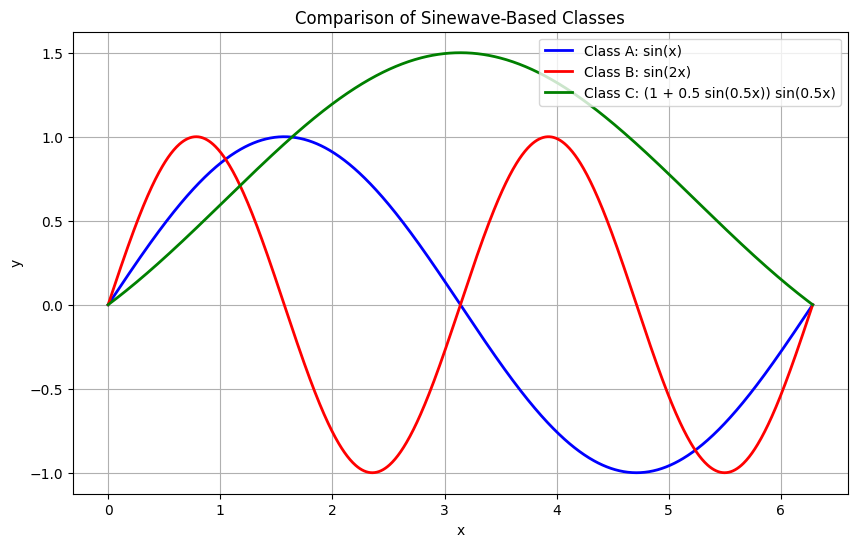

In [81]:
# Replot with smoother lines and higher contrast colors

# Generate data without noise for smooth curves
x = np.linspace(0, 2 * np.pi, 1000)
y_A_smooth = np.sin(x)
y_B_smooth = np.sin(2 * x)
y_C_smooth = (1 + 0.5 * np.sin(0.5 * x)) * np.sin(0.5 * x)

# Plot with distinct colors
plt.figure(figsize=(10, 6))
plt.plot(x, y_A_smooth, label="Class A: sin(x)", color='blue', linewidth=2)
plt.plot(x, y_B_smooth, label="Class B: sin(2x)", color='red', linewidth=2)
plt.plot(x, y_C_smooth, label="Class C: (1 + 0.5 sin(0.5x)) sin(0.5x)", color='green', linewidth=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Comparison of Sinewave-Based Classes")
plt.legend()
plt.grid(True)
plt.savefig('Sinewave_classes.pdf')
plt.show()


In [91]:
ewc_task_C_mean = np.mean(epoch_stats_no_ewc["ewc"]["val_task_C_during_B"], axis=0)
ewc_task_C_std = np.std(epoch_stats_no_ewc["ewc"]["val_task_C_during_B"], axis=0)
no_ewc_task_C_mean = np.mean(epoch_stats_no_ewc["no_ewc"]["val_task_C_during_B"], axis=0)
no_ewc_task_C_std = np.std(epoch_stats_no_ewc["no_ewc"]["val_task_C_during_B"], axis=0)
si_task_C_mean = np.mean(epoch_stats_other["si"]["C_during_B_val"], axis=0)
si_task_C_std = np.std(epoch_stats_other["si"]["C_during_B_val"], axis=0)
reh_task_C_mean = np.mean(epoch_stats_other["reh"]["C_during_B_val"], axis=0)
reh_task_C_std = np.std(epoch_stats_other["reh"]["C_during_B_val"], axis=0)

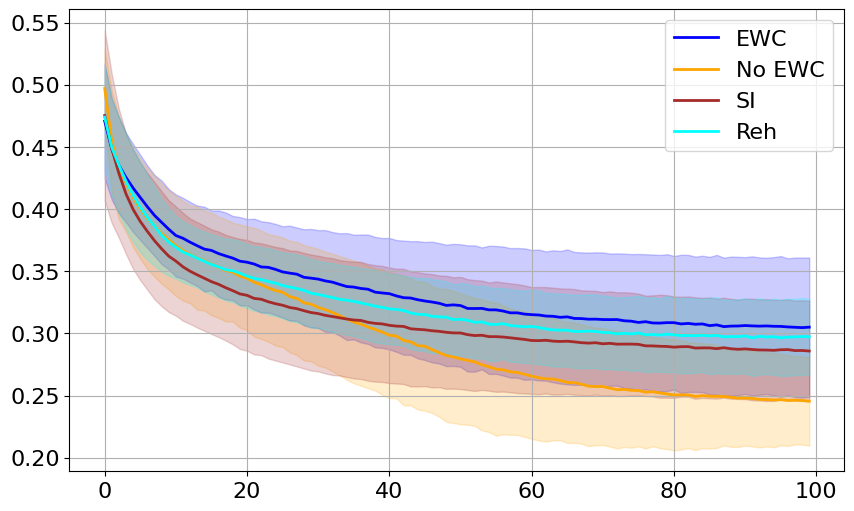

In [98]:
# Compute per-epoch average accuracy across all classes
avg_ewc = np.mean([ewc_initial_acc_mean, ewc_task_B_mean, ewc_task_C_mean], axis=0)
avg_no_ewc = np.mean([no_ewc_initial_acc_mean, no_ewc_task_B_mean, no_ewc_task_C_mean], axis=0)
avg_si = np.mean([si_A_during_A_mean, si_task_B_mean, si_task_C_mean], axis=0)
avg_reh = np.mean([reh_A_during_A_mean, reh_task_B_mean, reh_task_C_mean], axis=0)

# Compute per-epoch average standard deviation across all classes
avg_ewc_std = np.mean([ewc_initial_acc_std, ewc_task_B_std, ewc_task_C_std,], axis=0)
avg_no_ewc_std = np.mean([no_ewc_initial_acc_std, no_ewc_task_B_std, no_ewc_task_C_std,], axis=0)
avg_si_std = np.mean([si_A_during_A_std, si_task_B_std, si_task_C_std,], axis=0)
avg_reh_std = np.mean([reh_A_during_A_std, reh_task_B_std, reh_task_C_std,], axis=0)


# X-axis: 50 epochs
epochs = np.arange(len(avg_ewc))

# Plot
plt.figure(figsize=(10, 6))
# Plot EWC with variance band
plt.plot(epochs, avg_ewc, label='EWC', color='blue', linewidth=2)
plt.fill_between(epochs, avg_ewc - avg_ewc_std, avg_ewc + avg_ewc_std, color='blue', alpha=0.2)

# Plot No EWC with variance band
plt.plot(epochs, avg_no_ewc, label='No EWC', color='orange', linewidth=2)
plt.fill_between(epochs, avg_no_ewc - avg_no_ewc_std, avg_no_ewc + avg_no_ewc_std, color='orange', alpha=0.2)

# Plot SI with variance band
plt.plot(epochs, avg_si, label='SI', color='brown', linewidth=2)
plt.fill_between(epochs, avg_si - avg_si_std, avg_si + avg_si_std, color='brown', alpha=0.2)

# Plot Rehearsal with variance band
plt.plot(epochs, avg_reh, label='Reh', color='cyan', linewidth=2)
plt.fill_between(epochs, avg_reh - avg_reh_std, avg_reh + avg_reh_std, color='cyan', alpha=0.2)


# Labels, title, and legend
plt.xticks(fontsize=16)                 # Font size for x-axis ticks
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)
plt.grid(True)

# Save and show the plot
plt.savefig('cil_toy_avg_accuracy_plot.png')
plt.show()
